# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2


Group Number: 18

Group Members:
- Arvyno Pranata Limahardja (18222007)
- David Dewanto (18222027)
- Bastian Natanael Sibarani (18222053)
- Dedy Hofmanindo Saragih (18222085)

## Import Libraries

In [4]:
!pip install category_encoders

In [5]:
# Standard Library Imports
import os
import re
import math
import json
import random
import logging
import warnings
import gc
from datetime import datetime
from dataclasses import dataclass
from typing import Dict, List, Any, Optional, Tuple, Union, Set
from urllib.parse import urlparse, unquote, parse_qs
import pickle

# Core Data Science Libraries
import numpy as np
import pandas as pd
import joblib

# Network Analysis
import ipaddress

# Statistical Analysis
from scipy import stats
from scipy.stats import (
    chi2_contingency,
    median_abs_deviation,
    f_oneway,
    spearmanr
)

# Scikit-learn Core
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV
)

# Scikit-learn Preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import (
    mutual_info_classif,
    VarianceThreshold
)

# Scikit-learn Models
from sklearn.naive_bayes import BernoulliNB

# Scikit-learn Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Additional ML Libraries
from category_encoders import TargetEncoder

# Time Utilities
import time

## Import Dataset

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

In [10]:
class DatasetSplitter:
    """
    A class to handle dataset splitting with stratification and validation.

    Attributes:
        random_state (int): Random seed for reproducibility
        test_size (float): Proportion of dataset to include in validation split
        target_col (str): Name of the target column
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        test_size: float = 0.2,
        target_col: str = 'label',
        random_state: int = 42,
        verbose: bool = True
    ):
        """
        Initialize the DatasetSplitter.

        Args:
            test_size: Proportion of dataset for validation (default: 0.2)
            target_col: Name of target column (default: 'label')
            random_state: Random seed (default: 42)
            verbose: Whether to print details (default: True)
        """
        self.test_size = test_size
        self.target_col = target_col
        self.random_state = random_state
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Initialize split statistics
        self.split_stats = {}

    def validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame before splitting.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found in DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

        if df[self.target_col].isnull().any():
            raise ValueError("Target column contains missing values")

    def split_dataset(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Creates training and validation splits while preserving class distributions.

        Args:
            df: DataFrame containing the complete dataset

        Returns:
            tuple: (train_data, validation_data)
        """
        try:
            # Validate input
            self.validate_input(df)

            # Store initial state
            self.split_stats['initial_shape'] = df.shape
            self.split_stats['initial_class_dist'] = df[self.target_col].value_counts(normalize=True).to_dict()

            # Drop missing URL rows
            df = df.dropna(subset=['URL'])

            # Separate features and target
            X = df.drop(self.target_col, axis=1)
            y = df[self.target_col]

            # Create stratified split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y,
                test_size=self.test_size,
                random_state=self.random_state,
                stratify=y
            )

            # Reconstruct complete dataframes
            train_data = X_train.copy()
            train_data[self.target_col] = y_train

            validation_data = X_val.copy()
            validation_data[self.target_col] = y_val

            # Store split statistics
            self._calculate_split_statistics(train_data, validation_data)

            # Print statistics if verbose
            if self.verbose:
                self._print_split_summary()

            return train_data, validation_data

        except Exception as e:
            self.logger.error(f"Error in split_dataset: {str(e)}")
            raise

    def _calculate_split_statistics(
        self,
        train_data: pd.DataFrame,
        validation_data: pd.DataFrame
    ) -> None:
        """
        Calculate detailed statistics about the split.

        Args:
            train_data: Training DataFrame
            validation_data: Validation DataFrame
        """
        self.split_stats.update({
            'train_shape': train_data.shape,
            'validation_shape': validation_data.shape,
            'train_class_dist': train_data[self.target_col].value_counts(normalize=True).to_dict(),
            'validation_class_dist': validation_data[self.target_col].value_counts(normalize=True).to_dict(),
            'train_nulls': train_data.isnull().sum().to_dict(),
            'validation_nulls': validation_data.isnull().sum().to_dict()
        })

    def _print_split_summary(self) -> None:
        """Print formatted summary of the split results."""
        self.logger.info("\nDataset Split Summary")
        self.logger.info("-" * 50)

        # Size information
        self.logger.info(f"\nTotal samples: {self.split_stats['initial_shape'][0]}")
        self.logger.info(
            f"Training set size: {self.split_stats['train_shape'][0]} "
            f"({self.split_stats['train_shape'][0]/self.split_stats['initial_shape'][0]*100:.2f}%)"
        )
        self.logger.info(
            f"Validation set size: {self.split_stats['validation_shape'][0]} "
            f"({self.split_stats['validation_shape'][0]/self.split_stats['initial_shape'][0]*100:.2f}%)"
        )

        # Class distribution
        self.logger.info("\nClass Distribution:")
        self.logger.info("Original:")
        for cls, prop in self.split_stats['initial_class_dist'].items():
            self.logger.info(f"Class {cls}: {prop*100:.2f}%")

        self.logger.info("\nTraining:")
        for cls, prop in self.split_stats['train_class_dist'].items():
            self.logger.info(f"Class {cls}: {prop*100:.2f}%")

        self.logger.info("\nValidation:")
        for cls, prop in self.split_stats['validation_class_dist'].items():
            self.logger.info(f"Class {cls}: {prop*100:.2f}%")

    def get_split_statistics(self) -> Dict:
        """
        Get dictionary of split statistics.

        Returns:
            dict: Dictionary containing split statistics
        """
        return self.split_stats

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [12]:
@dataclass
class FeatureStats:
    """Data class to store feature statistics"""
    data_type: str
    distribution_type: Optional[str] = None
    imputation_strategy: str = ""

class MissingValueHandler:
    """
    A class to handle missing values in the dataset with specialized handling for URL-derived features.

    Attributes:
        metadata (dict): Additional feature metadata
        verbose (bool): Whether to print detailed information
        random_state (int): Random seed for reproducibility
    """

    def __init__(
        self,
        metadata: Optional[Dict] = None,
        verbose: bool = True,
        random_state: int = 42
    ):
        """
        Initialize the MissingValueHandler.

        Args:
            metadata: Dictionary containing feature metadata
            verbose: Whether to print details
            random_state: Random seed
        """
        self.metadata = metadata or {}
        self.verbose = verbose
        self.random_state = random_state
        self.strategy_summary = {}

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Initialize URL feature extractor components
        self.ip_pattern = r'^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$'

    def _validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

    def _analyze_distributions(self, df: pd.DataFrame) -> Dict[str, FeatureStats]:
        """
        Analyze distributions and determine imputation strategies.

        Args:
            df: Input DataFrame

        Returns:
            dict: Feature statistics and recommended strategies
        """
        numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df.select_dtypes(include=['object']).columns

        for col in numerical_columns:
            clean_data = df[col].dropna()
            if len(clean_data) > 0:
                stats = {
                    'mean': clean_data.mean(),
                    'median': clean_data.median(),
                    'std': clean_data.std(),
                    'skew': clean_data.skew()
                }

                # Determine distribution type
                mean_median_diff = abs(stats['mean'] - stats['median']) / stats['std']
                if mean_median_diff < 0.2 and abs(stats['skew']) < 0.5:
                    distribution = "Normal"
                    strategy = "Mean Imputation"
                else:
                    distribution = "Skewed"
                    strategy = "Median Imputation"

                self.strategy_summary[col] = FeatureStats(
                    data_type=str(df[col].dtype),
                    distribution_type=distribution,
                    imputation_strategy=strategy
                )

        # Handle categorical features
        for col in categorical_columns:
            if df[col].isnull().any():
                self.strategy_summary[col] = FeatureStats(
                    data_type=str(df[col].dtype),
                    imputation_strategy="Mode Imputation"
                )

        return self.strategy_summary

    def _extract_url_features(self, url: str) -> Dict[str, Any]:
        """
        Extract features from a URL.

        Args:
            url: URL string

        Returns:
            dict: Extracted features
        """
        if pd.isna(url):
            return {}

        try:
            # Parse URL
            parsed = urlparse(url)
            domain = parsed.netloc

            features = {
                'URLLength': len(url),
                'Domain': domain,
                'DomainLength': len(domain),
                'TLD': domain.split('.')[-1] if domain else '',
                'TLDLength': len(domain.split('.')[-1]) if domain else 0,
                'NoOfSubDomain': domain.count('.') if domain else 0,
                'IsHTTPS': url.startswith('https://'),
                'IsDomainIP': bool(re.match(self.ip_pattern, domain))
            }

            # Character analysis
            letters = sum(c.isalpha() for c in url)
            digits = sum(c.isdigit() for c in url)
            total_len = len(url)

            features.update({
                'NoOfLettersInURL': letters,
                'LetterRatioInURL': letters / total_len if total_len > 0 else 0,
                'NoOfDegitsInURL': digits,
                'DegitRatioInURL': digits / total_len if total_len > 0 else 0,
                'NoOfSpecialCharsInURL': total_len - letters - digits
            })

            return features

        except Exception as e:
            self.logger.warning(f"Error extracting URL features: {str(e)}")
            return {}

    def _impute_url_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Impute URL-derived features.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with imputed URL features
        """
        df_imputed = df.copy()

        # Process each URL
        for idx, row in df.iterrows():
            if pd.notna(row['URL']):
                features = self._extract_url_features(row['URL'])
                for feat, value in features.items():
                    if feat in df.columns and pd.isna(df_imputed.at[idx, feat]):
                        df_imputed.at[idx, feat] = value

        return df_imputed

    def _impute_standard_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Impute non-URL features using appropriate strategies.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with imputed standard features
        """
        df_imputed = df.copy()

        for col, stats in self.strategy_summary.items():
            if col in df.columns and df[col].isnull().any():
                try:
                    if stats.imputation_strategy == "Mean Imputation":
                        imputer = SimpleImputer(strategy='mean')
                    elif stats.imputation_strategy == "Median Imputation":
                        imputer = SimpleImputer(strategy='median')
                    elif stats.imputation_strategy == "Mode Imputation":
                        imputer = SimpleImputer(strategy='most_frequent')
                    else:
                        continue

                    df_imputed[col] = imputer.fit_transform(df[[col]])

                except Exception as e:
                    self.logger.warning(f"Error imputing column {col}: {str(e)}")

        return df_imputed

    def impute_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Handle missing values in the dataset.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with imputed values
        """
        try:
            # Validate input
            self._validate_input(df)

            # Store initial state
            initial_missing = df.isnull().sum()

            # Analyze distributions and determine strategies
            self._analyze_distributions(df)

            # Handle URL-derived features first
            df_imputed = self._impute_url_features(df)

            # Handle remaining features
            df_imputed = self._impute_standard_features(df_imputed)

            # Calculate and print statistics if verbose
            if self.verbose:
                final_missing = df_imputed.isnull().sum()
                self.logger.info("\nMissing Value Imputation Summary:")
                self.logger.info("-" * 50)

                for column in df.columns:
                    initial = initial_missing[column]
                    final = final_missing[column]
                    if initial > 0:
                        self.logger.info(f"\nColumn: {column}")
                        self.logger.info(f"Initial missing: {initial}")
                        self.logger.info(f"Final missing: {final}")
                        self.logger.info(f"Values imputed: {initial - final}")
                        if column in self.strategy_summary:
                            self.logger.info(f"Strategy used: {self.strategy_summary[column].imputation_strategy}")

            return df_imputed

        except Exception as e:
            self.logger.error(f"Error in impute_missing_values: {str(e)}")
            raise

    def get_imputation_statistics(self) -> Dict[str, Any]:
        """
        Get imputation statistics and strategies.

        Returns:
            dict: Dictionary containing imputation statistics
        """
        return {
            'strategy_summary': self.strategy_summary,
            'feature_metadata': self.metadata
        }

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [14]:
class OutlierProcessor:
    """
    A class to handle outlier detection and processing with specialized handling
    for URL-based features and standard numerical features.

    Attributes:
        variance_threshold (float): Threshold for variance filter
        correlation_threshold (float): Threshold for correlation analysis
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        variance_threshold: float = 0.1,
        correlation_threshold: float = 0.8,
        verbose: bool = True
    ):
        """
        Initialize the OutlierProcessor.

        Args:
            variance_threshold: Threshold for variance filter
            correlation_threshold: Threshold for correlation analysis
            verbose: Whether to print details
        """
        self.variance_threshold = variance_threshold
        self.correlation_threshold = correlation_threshold
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Store outlier statistics
        self.outlier_stats = {}

        # Initialize URL pattern detection
        self.url_patterns = {
            'url_encoding': r'%[0-9A-Fa-f]{2}',
            'double_encoding': r'%25[0-9A-Fa-f]{2}',
            'punycode': r'xn--',
            'ip_pattern': r'^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$'
        }

        # Character substitutions for detection
        self.char_substitutions = {
            '0': 'o', '1': 'l', '3': 'e', '4': 'a', '5': 's',
            '6': 'b', '7': 't', '8': 'b', '9': 'g'
        }

    def _validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

    def _determine_distribution(self, data: pd.Series) -> Tuple[str, str]:
        """
        Determine distribution type and appropriate outlier detection method.

        Args:
            data: Series of values to analyze

        Returns:
            tuple: (distribution_type, recommended_method)
        """
        try:
            mean = data.mean()
            median = data.median()
            std = data.std()
            skewness = data.skew()

            # Normalized mean-median difference
            mean_median_diff = abs(mean - median) / std if std != 0 else float('inf')

            if mean_median_diff < 0.2 and abs(skewness) < 0.5:
                return "Normal", "zscore"
            elif abs(skewness) < 1:
                return "Moderately-Skewed", "iqr"
            else:
                return "Highly-Skewed", "modified_zscore"

        except Exception as e:
            self.logger.warning(f"Error determining distribution: {str(e)}")
            return "Unknown", "iqr"

    def _detect_numerical_outliers(self, data: pd.Series, method: str) -> pd.Series:
        """
        Detect outliers in numerical data using specified method.

        Args:
            data: Series of values
            method: Detection method ('zscore', 'iqr', or 'modified_zscore')

        Returns:
            Series: Boolean mask indicating outlier positions
        """
        if method == "zscore":
            z_scores = np.abs((data - data.mean()) / data.std())
            return z_scores > 3

        elif method == "iqr":
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            return (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

        else:  # modified_zscore
            median = data.median()
            mad = median_abs_deviation(data)
            modified_z_scores = 0.6745 * (data - median) / mad
            return np.abs(modified_z_scores) > 3.5

    def _detect_url_outliers(self, url: str) -> Dict[str, Any]:
        """
        Detect URL-based outliers and suspicious patterns.

        Args:
            url: URL string to analyze

        Returns:
            dict: Dictionary of detected patterns and metrics
        """
        if pd.isna(url):
            return {
                'has_outliers': False,
                'outlier_count': 0,
                'outlier_ratio': 0.0,
                'patterns': []
            }

        patterns = []
        outlier_count = 0

        # Check URL encoding
        if re.search(self.url_patterns['url_encoding'], url):
            patterns.append('url_encoding')
            outlier_count += len(re.findall(self.url_patterns['url_encoding'], url))

        # Check double encoding
        if re.search(self.url_patterns['double_encoding'], url):
            patterns.append('double_encoding')
            outlier_count += len(re.findall(self.url_patterns['double_encoding'], url))

        # Check punycode
        if re.search(self.url_patterns['punycode'], url):
            patterns.append('punycode')
            outlier_count += 1

        # Check character substitutions
        domain = urlparse(url).netloc
        for digit, letter in self.char_substitutions.items():
            if digit in domain:
                patterns.append('char_substitution')
                outlier_count += domain.count(digit)

        return {
            'has_outliers': len(patterns) > 0,
            'outlier_count': outlier_count,
            'outlier_ratio': outlier_count / len(url) if len(url) > 0 else 0,
            'patterns': patterns
        }

    def process_outliers(self, df: pd.DataFrame, handling_method: str = 'clip') -> pd.DataFrame:
        """
        Process outliers in the dataset.

        Args:
            df: Input DataFrame
            handling_method: Method to handle outliers ('clip' or 'remove')

        Returns:
            DataFrame with processed outliers
        """
        try:
            # Validate input
            self._validate_input(df)
            df_processed = df.copy()

            # Initialize statistics
            self.outlier_stats = {
                'numerical': {},
                'url': {
                    'pattern_counts': {},
                    'outlier_ratios': []
                }
            }

            # Process numerical features
            numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
            for column in numerical_features:
                data = df[column].dropna()
                dist_type, method = self._determine_distribution(data)
                outliers = self._detect_numerical_outliers(data, method)

                # Store statistics
                self.outlier_stats['numerical'][column] = {
                    'distribution': dist_type,
                    'method': method,
                    'outlier_count': outliers.sum()
                }

                # Handle outliers
                if handling_method == 'clip':
                    if method == 'zscore':
                        mean, std = data.mean(), data.std()
                        df_processed[column] = data.clip(mean - 3*std, mean + 3*std)
                    elif method == 'iqr':
                        Q1, Q3 = data.quantile([0.25, 0.75])
                        IQR = Q3 - Q1
                        df_processed[column] = data.clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
                    else:
                        median = data.median()
                        mad = median_abs_deviation(data)
                        df_processed[column] = data.clip(
                            median - 3.5*mad/0.6745,
                            median + 3.5*mad/0.6745
                        )
                elif handling_method == 'remove':
                    df_processed = df_processed[~outliers]

            # Process URL features
            if 'URL' in df.columns:
                for idx, url in df['URL'].items():
                    if pd.notna(url):
                        url_stats = self._detect_url_outliers(url)

                        # Update pattern counts
                        for pattern in url_stats['patterns']:
                            self.outlier_stats['url']['pattern_counts'][pattern] = \
                                self.outlier_stats['url']['pattern_counts'].get(pattern, 0) + 1

                        # Store outlier ratio
                        if url_stats['outlier_ratio'] > 0:
                            self.outlier_stats['url']['outlier_ratios'].append(url_stats['outlier_ratio'])

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            return df_processed

        except Exception as e:
            self.logger.error(f"Error in process_outliers: {str(e)}")
            raise

    def _print_summary(self) -> None:
        """Print formatted summary of outlier processing results."""
        self.logger.info("\nOutlier Processing Summary")
        self.logger.info("-" * 50)

        # Numerical features summary
        self.logger.info("\nNumerical Features:")
        for column, stats in self.outlier_stats['numerical'].items():
            self.logger.info(f"\nColumn: {column}")
            self.logger.info(f"Distribution: {stats['distribution']}")
            self.logger.info(f"Method used: {stats['method']}")
            self.logger.info(f"Outliers detected: {stats['outlier_count']}")

        # URL patterns summary
        if self.outlier_stats['url']['pattern_counts']:
            self.logger.info("\nURL Patterns:")
            for pattern, count in self.outlier_stats['url']['pattern_counts'].items():
                self.logger.info(f"{pattern}: {count} occurrences")

            if self.outlier_stats['url']['outlier_ratios']:
                avg_ratio = np.mean(self.outlier_stats['url']['outlier_ratios'])
                self.logger.info(f"\nAverage URL outlier ratio: {avg_ratio:.4f}")

    def get_outlier_statistics(self) -> Dict[str, Any]:
        """
        Get outlier processing statistics.

        Returns:
            dict: Dictionary containing outlier statistics
        """
        return self.outlier_stats

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [16]:
class DuplicateHandler:
    """
    A class to handle duplicate detection and processing with specialized handling
    for URL-based duplicates and similar records.

    Attributes:
        verbose (bool): Whether to print detailed information
        min_similarity (float): Minimum similarity threshold for URL matching
    """

    def __init__(
        self,
        verbose: bool = True,
        min_similarity: float = 0.9
    ):
        """
        Initialize the DuplicateHandler.

        Args:
            verbose: Whether to print details
            min_similarity: Minimum similarity threshold for URL matching
        """
        self.verbose = verbose
        self.min_similarity = min_similarity

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Store duplicate statistics
        self.duplicate_stats = {
            'initial_rows': 0,
            'final_rows': 0,
            'exact_duplicates': 0,
            'url_duplicates': 0,
            'domain_duplicates': 0,
            'total_removed': 0,
            'percentage_retained': 0
        }

    def _validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

    def _find_exact_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Find and remove exact duplicates.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with exact duplicates removed
        """
        # Count exact duplicates
        self.duplicate_stats['exact_duplicates'] = df.duplicated().sum()

        # Remove exact duplicates
        return df.drop_duplicates()

    def _merge_url_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Find and merge URL-based duplicates.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with merged URL duplicates
        """
        if 'URL' not in df.columns:
            return df

        # Count URL duplicates
        url_duplicates = df[df['URL'].notna()].duplicated(subset=['URL']).sum()
        self.duplicate_stats['url_duplicates'] = url_duplicates

        if url_duplicates == 0:
            return df

        # Get duplicate URLs for merging
        duplicate_urls = df[df.duplicated(subset=['URL'], keep=False)]
        unique_urls = duplicate_urls['URL'].unique()

        # Process each set of URL duplicates
        merged_rows = []
        non_duplicate_mask = ~df['URL'].isin(unique_urls)

        for url in unique_urls:
            # Get all rows for this URL
            url_rows = df[df['URL'] == url]

            # Create merged row
            merged_row = {}
            for column in df.columns:
                values = url_rows[column].dropna()
                if len(values) > 0:
                    if df[column].dtype == 'boolean':
                        # For boolean columns, use most common value
                        merged_row[column] = values.mode().iloc[0]
                    elif pd.api.types.is_numeric_dtype(df[column].dtype):
                        # For numeric columns, use mean
                        merged_row[column] = values.mean()
                    else:
                        # For other types, use first non-null value
                        merged_row[column] = values.iloc[0]
                else:
                    merged_row[column] = np.nan

            merged_rows.append(merged_row)

        # Combine non-duplicates with merged rows
        return pd.concat([
            df[non_duplicate_mask],
            pd.DataFrame(merged_rows)
        ], ignore_index=True)

    def _analyze_domain_duplicates(self, df: pd.DataFrame) -> None:
        """
        Analyze domain-based duplicates for reporting.

        Args:
            df: Input DataFrame
        """
        if 'Domain' in df.columns:
            self.duplicate_stats['domain_duplicates'] = \
                df[df['Domain'].notna()].duplicated(subset=['Domain']).sum()

    def process_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Process duplicates in the dataset.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with duplicates handled
        """
        try:
            # Validate input
            self._validate_input(df)

            # Store initial state
            self.duplicate_stats['initial_rows'] = len(df)

            # Remove exact duplicates
            df_cleaned = self._find_exact_duplicates(df)

            # Merge URL duplicates
            df_cleaned = self._merge_url_duplicates(df_cleaned)

            # Analyze domain duplicates for reporting
            self._analyze_domain_duplicates(df_cleaned)

            # Update final statistics
            self.duplicate_stats['final_rows'] = len(df_cleaned)
            self.duplicate_stats['total_removed'] = \
                self.duplicate_stats['initial_rows'] - self.duplicate_stats['final_rows']
            self.duplicate_stats['percentage_retained'] = \
                (self.duplicate_stats['final_rows'] / self.duplicate_stats['initial_rows'] * 100)

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            return df_cleaned

        except Exception as e:
            self.logger.error(f"Error in process_duplicates: {str(e)}")
            raise

    def _print_summary(self) -> None:
        """Print formatted summary of duplicate processing results."""
        self.logger.info("\nDuplicate Processing Summary")
        self.logger.info("-" * 30)

        self.logger.info(f"Initial number of rows: {self.duplicate_stats['initial_rows']:,}")
        self.logger.info(f"Exact duplicates removed: {self.duplicate_stats['exact_duplicates']:,}")
        self.logger.info(f"URL-based duplicates handled: {self.duplicate_stats['url_duplicates']:,}")
        self.logger.info(f"Domain-based duplicates found: {self.duplicate_stats['domain_duplicates']:,}")
        self.logger.info(f"Total rows removed: {self.duplicate_stats['total_removed']:,}")
        self.logger.info(f"Final number of rows: {self.duplicate_stats['final_rows']:,}")
        self.logger.info(
            f"Percentage of data retained: {self.duplicate_stats['percentage_retained']:.2f}%"
        )

    def get_duplicate_statistics(self) -> Dict[str, Any]:
        """
        Get duplicate processing statistics.

        Returns:
            dict: Dictionary containing duplicate statistics
        """
        return self.duplicate_stats

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [18]:
class FeatureEngineer:
    """
    A class to handle feature selection, creation, and engineering with specialized focus
    on URL-based features and feature importance analysis.

    Attributes:
        variance_threshold (float): Threshold for variance filter
        max_categories (int): Maximum categories for categorical features
        p_value_threshold (float): Threshold for statistical tests
        mi_threshold (float): Threshold for mutual information
        correlation_threshold (float): Threshold for correlation analysis
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        variance_threshold: float = 0.1,
        max_categories: int = 50,
        p_value_threshold: float = 0.05,
        correlation_threshold: float = 0.8,
        verbose: bool = True
    ):
        """
        Initialize the FeatureEngineer.

        Args:
            variance_threshold: Threshold for variance filter
            max_categories: Maximum allowed categories for categorical features
            p_value_threshold: Threshold for statistical significance
            mi_threshold: Threshold for mutual information
            correlation_threshold: Threshold for correlation analysis
            verbose: Whether to print details
        """
        self.variance_threshold = variance_threshold
        self.max_categories = max_categories
        self.p_value_threshold = p_value_threshold
        self.correlation_threshold = correlation_threshold
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Store feature statistics
        self.feature_stats = {}

    def _validate_input(self, df: pd.DataFrame, target_column: str) -> None:
        """
        Validate input DataFrame and target column.

        Args:
            df: Input DataFrame to validate
            target_column: Name of target column

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

        if target_column not in df.columns:
            raise ValueError(f"Target column '{target_column}' not found in DataFrame")

    def _analyze_numeric_features(
        self,
        X: pd.DataFrame,
        y: pd.Series
    ) -> Tuple[List[str], List[Tuple[str, str]]]:
        """
        Analyze numeric features using statistical tests.

        Args:
            X: Feature DataFrame
            y: Target series

        Returns:
            tuple: (selected_features, dropped_features)
        """
        selected_features = []
        dropped_features = []

        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
        for feature in numeric_features:
            # Initialize feature statistics
            self.feature_stats[feature] = {}

            # Calculate variance
            variance = X[feature].var()
            self.feature_stats[feature]['variance'] = variance

            if variance < self.variance_threshold:
                dropped_features.append((feature, f'Low Variance ({variance:.4f})'))
                continue

            try:
                # ANOVA test
                groups = [X[feature][y == val].dropna() for val in y.unique()]
                f_stat, p_value = f_oneway(*groups)
                self.feature_stats[feature].update({
                    'f_statistic': f_stat,
                    'p_value': p_value
                })

                if p_value < self.p_value_threshold:
                    selected_features.append(feature)
                else:
                    reason = f'High p-value ({p_value:.4f})'
                    dropped_features.append((feature, reason))

            except Exception as e:
                self.logger.warning(f"Error processing numeric feature {feature}: {e}")
                dropped_features.append((feature, f'Error: {str(e)}'))

        return selected_features, dropped_features

    def _analyze_categorical_features(
        self,
        X: pd.DataFrame,
        y: pd.Series
    ) -> Tuple[List[str], List[Tuple[str, str]]]:
        """
        Analyze categorical features using statistical tests.

        Args:
            X: Feature DataFrame
            y: Target series

        Returns:
            tuple: (selected_features, dropped_features)
        """
        selected_features = []
        dropped_features = []

        categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns
        for feature in categorical_features:
            # Initialize feature statistics
            self.feature_stats[feature] = {}

            try:
                unique_count = X[feature].nunique()
                if unique_count > self.max_categories:
                    dropped_features.append((feature, f'Too Many Categories ({unique_count})'))
                    continue

                # Chi-square test
                contingency = pd.crosstab(X[feature], y)
                chi2, p_value, _, _ = chi2_contingency(contingency)
                self.feature_stats[feature].update({
                    'chi_square': chi2,
                    'p_value': p_value
                })

                if p_value < self.p_value_threshold:
                    selected_features.append(feature)
                else:
                    reason = f'High p-value ({p_value:.4f})'
                    dropped_features.append((feature, reason))

            except Exception as e:
                self.logger.warning(f"Error processing categorical feature {feature}: {e}")
                dropped_features.append((feature, f'Error: {str(e)}'))

        return selected_features, dropped_features

    def _check_correlations(
        self,
        df: pd.DataFrame,
        features: List[str]
    ) -> List[str]:
        """
        Check for correlations between features.

        Args:
            df: Input DataFrame
            features: List of features to check

        Returns:
            list: Final selected features after correlation check
        """
        final_features = set(features)

        for i, feat_a in enumerate(features):
            if feat_a not in final_features:
                continue

            for feat_b in features[i + 1:]:
                if feat_b not in final_features:
                    continue

                try:
                    # Calculate correlation based on data type
                    if df[feat_a].dtype in ['float64', 'int64'] and \
                       df[feat_b].dtype in ['float64', 'int64']:
                        corr, _ = spearmanr(df[feat_a].fillna(0), df[feat_b].fillna(0))
                        corr = abs(corr)
                    else:
                        # Use Cramer's V for categorical features
                        contingency = pd.crosstab(
                            df[feat_a].fillna('missing'),
                            df[feat_b].fillna('missing')
                        )
                        chi2, _, _, _ = chi2_contingency(contingency)
                        n = contingency.sum().sum()
                        min_dim = min(contingency.shape) - 1
                        corr = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

                    if corr >= self.correlation_threshold:
                        # Compare mutual information scores
                        score_a = self.feature_stats[feat_a].get('mutual_info', 0)
                        score_b = self.feature_stats[feat_b].get('mutual_info', 0)

                        if score_a >= score_b:
                            final_features.discard(feat_b)
                            self.logger.info(
                                f"Removed {feat_b} due to high correlation with {feat_a}"
                            )
                        else:
                            final_features.discard(feat_a)
                            self.logger.info(
                                f"Removed {feat_a} due to high correlation with {feat_b}"
                            )
                            break

                except Exception as e:
                    self.logger.warning(
                        f"Error calculating correlation between {feat_a} and {feat_b}: {e}"
                    )

        return list(final_features)

    def select_features(
        self,
        df: pd.DataFrame,
        target_column: str
    ) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Select important features from the dataset.

        Args:
            df: Input DataFrame
            target_column: Name of target column

        Returns:
            tuple: (DataFrame with selected features, Selection results)
        """
        try:
            # Validate input
            self._validate_input(df, target_column)

            # Separate features and target
            X = df.drop(columns=[target_column])
            y = df[target_column]

            # Process features by type
            numeric_selected, numeric_dropped = self._analyze_numeric_features(X, y)
            categorical_selected, categorical_dropped = self._analyze_categorical_features(X, y)

            # Combine and check correlations
            all_selected = numeric_selected + categorical_selected
            final_features = self._check_correlations(df, all_selected)

            # Create results dictionary
            results = {
                'selected_features': final_features,
                'dropped_features': numeric_dropped + categorical_dropped,
                'feature_stats': self.feature_stats
            }

            # Return DataFrame with selected features AND target column
            return df[final_features + [target_column]], results

        except Exception as e:
            self.logger.error(f"Error in select_features: {str(e)}")
            raise

    def transform(self, df: pd.DataFrame, selected_features) -> pd.DataFrame:
        """
        Transform new data using the feature selection rules learned during fitting.
        This method should be used on validation or test data.

        Args:
            df: Input DataFrame to transform

        Returns:
            DataFrame with selected features

        Raises:
            ValueError: If transform is called before select_features
        """
        try:
            if selected_features:
                df_selected = df[selected_features]

            # Return DataFrame with only the selected features
            return df_selected

        except Exception as e:
            self.logger.error(f"Error in transform: {str(e)}")
            raise

    def _print_summary(self, results: Dict[str, Any]) -> None:
        """Print formatted summary of feature selection results."""
        self.logger.info("\nFeature Selection Summary")
        self.logger.info("-" * 50)

        self.logger.info(f"\nSelected Features ({len(results['selected_features'])}):")
        for feature in results['selected_features']:
            stats = self.feature_stats[feature]
            self.logger.info(f"\n{feature}:")
            for stat, value in stats.items():
                self.logger.info(f"- {stat}: {value:.4f}")

        self.logger.info(f"\nDropped Features ({len(results['dropped_features'])}):")
        for feature, reason in results['dropped_features']:
            self.logger.info(f"{feature}: {reason}")

    def get_feature_statistics(self) -> Dict[str, Any]:
        """
        Get feature selection statistics.

        Returns:
            dict: Dictionary containing feature statistics
        """
        return self.feature_stats

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

In [21]:
# Example

# from sklearn.base import BaseEstimator, TransformerMixin

# class FeatureEncoder(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):

#         # Fit the encoder here

#         return self

#     def transform(self, X):
#         X_encoded = X.copy()

#         # Encode the categorical variables here

#         return X_encoded

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [23]:
class FeatureScaler:
    """
    A class to handle feature scaling with specialized handling for different feature types.
    Supports standard scaling, min-max scaling, and power transformation.

    Attributes:
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        verbose: bool = True
    ):
        """
        Initialize the FeatureScaler.

        Args:
            verbose: Whether to print details
        """
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Initialize feature categories
        self.feature_categories = {
            'numerical': [],    # For general numeric features
            'ratio': [],       # For features between 0 and 1
            'skewed': [],      # For highly skewed features
            'boolean': [],     # For binary features
        }

        # Initialize scalers
        self.scalers = {
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
            'power': PowerTransformer(method='yeo-johnson')
        }

        # Track fitting status
        self.is_fitted = False

        # Store scaling statistics
        self.scaling_stats = {}

    def _validate_input(self, X: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            X: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if X.empty:
            raise ValueError("DataFrame cannot be empty")

    def _categorize_features(self, X: pd.DataFrame) -> None:
        """
        Categorize features based on their characteristics.
        """
        try:
            # Reset feature categories
            for category in ['numerical', 'ratio', 'skewed', 'boolean']:
                self.feature_categories[category] = []

            for column in X.columns:
                # Categorize based on data characteristics
                if X[column].dtype == 'boolean' or (
                    X[column].nunique() == 2 and
                    set(X[column].unique()).issubset({0, 1, True, False})
                ):
                    self.feature_categories['boolean'].append(column)
                elif pd.api.types.is_numeric_dtype(X[column]):
                    # For numeric features, check if it's a ratio or skewed
                    if 0 <= X[column].min() and X[column].max() <= 1:
                        self.feature_categories['ratio'].append(column)
                    else:
                        skewness = X[column].skew()
                        if abs(skewness) > 1:
                            self.feature_categories['skewed'].append(column)
                        else:
                            self.feature_categories['numerical'].append(column)
                else:
                    # For non-numeric features, try to convert to numeric if possible
                    try:
                        numeric_series = pd.to_numeric(X[column])
                        self.feature_categories['numerical'].append(column)
                        self.logger.warning(
                            f"Column {column} was converted to numeric for scaling"
                        )
                    except:
                        self.logger.warning(
                            f"Column {column} could not be scaled (non-numeric)"
                        )
                        self.feature_categories['excluded'].append(column)

        except Exception as e:
            self.logger.error(f"Error in feature categorization: {str(e)}")
            raise

    def _calculate_scaling_stats(self, X: pd.DataFrame) -> None:
        """
        Calculate scaling statistics for each feature.

        Args:
            X: Input DataFrame
        """
        for category, features in self.feature_categories.items():
            if category != 'excluded':
                for feature in features:
                    self.scaling_stats[feature] = {
                        'category': category,
                        'original_stats': {
                            'mean': X[feature].mean(),
                            'std': X[feature].std(),
                            'min': X[feature].min(),
                            'max': X[feature].max(),
                            'skew': X[feature].skew()
                        }
                    }

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Fit scalers and transform data.
        Use this only on training data.

        Args:
            X: Input DataFrame to fit and transform

        Returns:
            Scaled DataFrame
        """
        try:
            # Validate input
            self._validate_input(X)

            # Categorize features
            self._categorize_features(X)

            # Calculate initial statistics
            self._calculate_scaling_stats(X)

            # Transform data
            transformed_data = {}

            # Transform skewed features
            if self.feature_categories['skewed']:
                transformed_data['power'] = self.scalers['power'].fit_transform(
                    X[self.feature_categories['skewed']]
                )

            # Transform numerical features
            if self.feature_categories['numerical']:
                transformed_data['standard'] = self.scalers['standard'].fit_transform(
                    X[self.feature_categories['numerical']]
                )

            # Transform ratio features
            if self.feature_categories['ratio']:
                transformed_data['minmax'] = self.scalers['minmax'].fit_transform(
                    X[self.feature_categories['ratio']]
                )

            # Keep boolean features as is
            if self.feature_categories['boolean']:
                transformed_data['boolean'] = X[self.feature_categories['boolean']].astype(float).values

            # Combine all transformed features
            scaled_arrays = [arr for arr in transformed_data.values()]
            if scaled_arrays:
                scaled_array = np.hstack(scaled_arrays)

                # Create column names
                columns = (self.feature_categories['skewed'] +
                         self.feature_categories['numerical'] +
                         self.feature_categories['ratio'] +
                         self.feature_categories['boolean'])

                result = pd.DataFrame(scaled_array, columns=columns, index=X.index)
            else:
                result = pd.DataFrame(index=X.index)

            self.is_fitted = True

            # Calculate post-scaling statistics
            self._update_scaling_stats(result)

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            # Memory cleanup
            gc.collect()

            return result

        except Exception as e:
            self.logger.error(f"Error in fit_transform: {str(e)}")
            raise

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform data using fitted scalers.
        Use this on validation/test data.

        Args:
            X: Input DataFrame to transform

        Returns:
            Scaled DataFrame
        """
        if not self.is_fitted:
            raise ValueError("Scalers must be fitted before calling transform")

        try:
            transformed_data = {}

            # Check which features are available in input data
            available_skewed = [f for f in self.feature_categories['skewed'] if f in X.columns]
            available_numerical = [f for f in self.feature_categories['numerical'] if f in X.columns]
            available_ratio = [f for f in self.feature_categories['ratio'] if f in X.columns]
            available_boolean = [f for f in self.feature_categories['boolean'] if f in X.columns]

            # Log any missing features
            all_expected = (self.feature_categories['skewed'] +
                        self.feature_categories['numerical'] +
                        self.feature_categories['ratio'] +
                        self.feature_categories['boolean'])
            missing_features = set(all_expected) - set(X.columns)
            if missing_features:
                self.logger.warning(f"Missing features in transform input: {missing_features}")

            # Transform skewed features
            if available_skewed:
                transformed_data['power'] = self.scalers['power'].transform(
                    X[available_skewed]
                )

            # Transform numerical features
            if available_numerical:
                transformed_data['standard'] = self.scalers['standard'].transform(
                    X[available_numerical]
                )

            # Transform ratio features
            if available_ratio:
                transformed_data['minmax'] = self.scalers['minmax'].transform(
                    X[available_ratio]
                )

            # Keep boolean features as is
            if available_boolean:
                transformed_data['boolean'] = X[available_boolean].astype(float).values

            # Combine all transformed features
            scaled_arrays = [arr for arr in transformed_data.values()]
            if scaled_arrays:
                scaled_array = np.hstack(scaled_arrays)

                # Create column names
                columns = (available_skewed +
                        available_numerical +
                        available_ratio +
                        available_boolean)

                result = pd.DataFrame(scaled_array, columns=columns, index=X.index)
            else:
                result = pd.DataFrame(index=X.index)

            # Memory cleanup
            gc.collect()

            return result

        except Exception as e:
            self.logger.error(f"Error in transform: {str(e)}")
            raise

    def _update_scaling_stats(self, scaled_df: pd.DataFrame) -> None:
        """
        Update scaling statistics with post-scaling metrics.

        Args:
            scaled_df: Scaled DataFrame
        """
        for feature in scaled_df.columns:
            self.scaling_stats[feature]['scaled_stats'] = {
                'mean': scaled_df[feature].mean(),
                'std': scaled_df[feature].std(),
                'min': scaled_df[feature].min(),
                'max': scaled_df[feature].max(),
                'skew': scaled_df[feature].skew()
            }

    def _print_summary(self) -> None:
        """Print formatted summary of scaling results."""
        self.logger.info("\nFeature Scaling Summary")
        self.logger.info("-" * 50)

        for category, features in self.feature_categories.items():
            if features and category != 'excluded':
                self.logger.info(f"\n{category.capitalize()} Features:")
                for feature in features:
                    stats = self.scaling_stats[feature]
                    self.logger.info(f"\n{feature}:")
                    self.logger.info("Original statistics:")
                    for stat, value in stats['original_stats'].items():
                        self.logger.info(f"- {stat}: {value:.4f}")
                    if 'scaled_stats' in stats:
                        self.logger.info("Scaled statistics:")
                        for stat, value in stats['scaled_stats'].items():
                            self.logger.info(f"- {stat}: {value:.4f}")

    def get_feature_categories(self) -> Dict[str, List[str]]:
        """
        Get the categorized features.

        Returns:
            dict: Dictionary of feature categories
        """
        return self.feature_categories

    def get_scaling_statistics(self) -> Dict[str, Any]:
        """
        Get scaling statistics.

        Returns:
            dict: Dictionary containing scaling statistics
        """
        return self.scaling_stats

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [25]:
class FeatureEncoder:
    """
    A class to handle feature encoding with specialized handling for different feature types.
    Supports label encoding, target encoding, and boolean conversion.

    Attributes:
        target_col (str): Name of target column
        verbose (bool): Whether to print detailed information
        random_state (int): Random seed for reproducibility
    """

    def __init__(
        self,
        target_col: str = 'label',
        verbose: bool = True,
        random_state: int = 42
    ):
        """
        Initialize the FeatureEncoder.

        Args:
            target_col: Name of target column
            verbose: Whether to print details
            random_state: Random seed
        """
        self.target_col = target_col
        self.verbose = verbose
        self.random_state = random_state

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Initialize encoders
        self.label_encoders = {}
        self.target_encoder = None

        # Store encoding statistics
        self.encoding_stats = {
            'boolean_features': {},
            'categorical_features': {},
            'encoded_features': {}
        }

        # Track fitting status
        self.is_fitted = False

    def _validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

    def _encode_boolean_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert boolean features to integers.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with encoded boolean features
        """
        bool_features = [
            'IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle',
            'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription',
            'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
            'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
            'Crypto', 'HasCopyrightInfo', 'label'
        ]

        df_encoded = df.copy()
        for feature in bool_features:
            if feature in df.columns:
                try:
                    original_count = len(df[feature])
                    missing_count = df[feature].isnull().sum()

                    if df[feature].dtype == 'boolean' or set(df[feature].dropna().unique()).issubset({0, 1, True, False}):
                        # Store statistics before encoding
                        if not pd.isnull(df[feature]).all():
                            true_ratio = df[feature].mean()
                            mode_value = df[feature].mode()[0]
                        else:
                            true_ratio = np.nan
                            mode_value = False

                        # Store feature statistics
                        self.encoding_stats['boolean_features'][feature] = {
                            'original_count': original_count,
                            'missing_count': missing_count,
                            'true_ratio': true_ratio,
                            'mode_value': mode_value
                        }

                        # Convert to int
                        df_encoded[feature] = df_encoded[feature].fillna(mode_value).astype(int)

                except Exception as e:
                    self.logger.warning(f"Error encoding boolean feature {feature}: {str(e)}")

        return df_encoded

    def _encode_categorical_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Encode categorical features using appropriate methods.

        Args:
            df: Input DataFrame

        Returns:
            DataFrame with encoded categorical features
        """
        df_encoded = df.copy()
        categorical_features = df.select_dtypes(include=['object']).columns

        for feature in categorical_features:
            try:
                if feature == self.target_col:
                    continue

                # Store original statistics
                self.encoding_stats['categorical_features'][feature] = {
                    'unique_values': df[feature].nunique(),
                    'missing_count': df[feature].isnull().sum(),
                    'value_counts': df[feature].value_counts().to_dict()
                }

                # Create label encoder for the feature
                le = LabelEncoder()
                non_null_mask = df[feature].notna()

                if non_null_mask.any():
                    non_null_values = df.loc[non_null_mask, feature]
                    encoded_values = le.fit_transform(non_null_values)
                    df_encoded.loc[non_null_mask, feature] = encoded_values

                    # Store encoder and mapping
                    self.label_encoders[feature] = le
                    self.encoding_stats['encoded_features'][feature] = {
                        'unique_encoded_values': len(le.classes_),
                        'mapping': dict(zip(le.classes_, range(len(le.classes_))))
                    }

            except Exception as e:
                self.logger.warning(f"Error encoding categorical feature {feature}: {str(e)}")

        return df_encoded

    def _encode_binary(self, df: pd.DataFrame) -> tuple:
        """
        Perform binning on numerical columns into binary values (0 and 1).

        Args:
            df: Input DataFrame
            numerical_columns: List of numerical column names

        Returns:
            tuple: (Binned DataFrame, Dictionary of descriptions)
        """
        df_encoded = df.copy()
        numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

        for col in numerical_features:
            col_data = df[col].dropna()
            if len(col_data) == 0:
                continue

            # Calculate statistics
            mean = col_data.mean()
            median = col_data.median()
            std = col_data.std()
            skewness = col_data.skew()

            # Normalized mean-median difference
            mean_median_diff = abs(mean - median) / std if std != 0 else float('inf')

            if mean_median_diff < 0.2 and abs(skewness) < 0.5:
                # Use the mean as the threshold for nearly normal distributions
                threshold = mean
            elif abs(skewness) < 1:
                # Use the median as the threshold for moderately skewed distributions
                threshold = median
            else:
                # Use a custom rule for highly skewed distributions (e.g., 75th percentile)
                threshold = col_data.quantile(0.75)

            # Apply binary binning
            df_encoded[col] = (df[col] >= threshold).astype(int)

        return df_encoded

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fit encoders and transform data.
        Use this only on training data.

        Args:
            df: Input DataFrame to fit and transform

        Returns:
            Encoded DataFrame
        """
        try:
            # Validate input
            self._validate_input(df)

            # Encode boolean features
            df_encoded = self._encode_boolean_features(df)

            # Encode categorical features
            df_encoded = self._encode_categorical_features(df_encoded)

            # Encode numerical features into binary values
            df_encoded = self._encode_binary(df_encoded)

            self.is_fitted = True

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            return df_encoded

        except Exception as e:
            self.logger.error(f"Error in fit_transform: {str(e)}")
            raise

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Transform data using fitted encoders.
        Use this on validation/test data.

        Args:
            df: Input DataFrame to transform

        Returns:
            Encoded DataFrame
        """
        if not self.is_fitted:
            raise ValueError("Encoders must be fitted before calling transform")

        try:
            # Encode boolean features
            df_encoded = self._encode_boolean_features(df)

            # Encode numerical features
            df_encoded = self._encode_binary(df_encoded)

            # Encode categorical features using fitted encoders
            for feature, encoder in self.label_encoders.items():
                if feature in df.columns:
                    non_null_mask = df[feature].notna()
                    if non_null_mask.any():
                        # Handle unseen categories
                        unique_values = df.loc[non_null_mask, feature].unique()
                        unknown_values = set(unique_values) - set(encoder.classes_)

                        if unknown_values:
                            self.logger.warning(
                                f"Found unknown categories in {feature}: {unknown_values}"
                            )
                            # Replace unknown values with mode from training
                            mode_value = encoder.classes_[0]  # Most frequent in training
                            for val in unknown_values:
                                df_encoded.loc[df[feature] == val, feature] = mode_value

                        # Transform known values
                        valid_mask = df_encoded[feature].isin(encoder.classes_)
                        df_encoded.loc[valid_mask, feature] = encoder.transform(
                            df_encoded.loc[valid_mask, feature]
                        )

            return df_encoded

        except Exception as e:
            self.logger.error(f"Error in transform: {str(e)}")
            raise

    def _print_summary(self) -> None:
        """Print formatted summary of encoding results."""
        self.logger.info("\nFeature Encoding Summary")
        self.logger.info("-" * 50)

        # Boolean features summary
        if self.encoding_stats['boolean_features']:
            self.logger.info("\nBoolean Features:")
            for feature, stats in self.encoding_stats['boolean_features'].items():
                self.logger.info(f"\n{feature}:")
                self.logger.info(f"- Original count: {stats['original_count']}")
                self.logger.info(f"- Missing values: {stats['missing_count']}")
                self.logger.info(f"- True ratio: {stats['true_ratio']:.4f}")
                self.logger.info(f"- Mode value: {stats['mode_value']}")

        # Categorical features summary
        if self.encoding_stats['categorical_features']:
            self.logger.info("\nCategorical Features:")
            for feature, stats in self.encoding_stats['categorical_features'].items():
                self.logger.info(f"\n{feature}:")
                self.logger.info(f"- Unique values: {stats['unique_values']}")
                self.logger.info(f"- Missing values: {stats['missing_count']}")

    def get_encoding_statistics(self) -> Dict[str, Any]:
        """
        Get encoding statistics.

        Returns:
            dict: Dictionary containing encoding statistics
        """
        return self.encoding_stats

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [27]:
class ImbalanceHandler:
    """
    A class to handle dataset imbalance using various resampling techniques.
    Supports SMOTE, random undersampling, SMOTEENN, and class weights.

    Attributes:
        target_col (str): Name of target column
        random_state (int): Random seed for reproducibility
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        target_col: str = 'label',
        random_state: int = 42,
        verbose: bool = True
    ):
        """
        Initialize the ImbalanceHandler.

        Args:
            target_col: Name of target column
            random_state: Random seed
            verbose: Whether to print details
        """
        self.target_col = target_col
        self.random_state = random_state
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Store imbalance handling results
        self.results = {
            'original': {},
            'smote': {},
            'undersampling': {},
            'smoteenn': {},
            'class_weights': None
        }

        # Track processing status
        self.is_processed = False

    def _validate_input(self, df: pd.DataFrame) -> None:
        """
        Validate input DataFrame.

        Args:
            df: Input DataFrame to validate

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if df.empty:
            raise ValueError("DataFrame cannot be empty")

        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found in DataFrame")

        # Check for appropriate number of classes
        n_classes = len(np.unique(df[self.target_col]))
        if n_classes < 2:
            raise ValueError(
                f"Target variable must have at least 2 classes for imbalance handling. "
                f"Currently has {n_classes} class(es)."
            )

        # Check for missing values
        if df.isnull().any().any():
            raise ValueError("Dataset contains missing values. Please handle them before resampling.")

    def _calculate_class_distribution(self, y: pd.Series) -> Dict[Any, float]:
        """
        Calculate class distribution.

        Args:
            y: Target series

        Returns:
            dict: Class distribution
        """
        return dict(y.value_counts(normalize=True))

    def _store_distribution_stats(self, name: str, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Store distribution statistics for a given resampling method.

        Args:
            name: Name of resampling method
            X: Feature DataFrame
            y: Target series
        """
        self.results[name] = {
            'shape': X.shape,
            'class_distribution': self._calculate_class_distribution(y)
        }

    def handle_imbalance(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Process class imbalance using multiple methods.

        Args:
            df: Input DataFrame

        Returns:
            dict: Dictionary containing resampled datasets and class weights
        """
        try:
            # Validate input
            self._validate_input(df)

            # Separate features and target
            X = df.drop(self.target_col, axis=1)
            y = df[self.target_col]

            # Store original distribution
            self._store_distribution_stats('original', X, y)

            # Apply SMOTE
            self.logger.info("\nApplying SMOTE...")
            smote = SMOTE(random_state=self.random_state)
            X_smote, y_smote = smote.fit_resample(X, y)
            self._store_distribution_stats('smote', X_smote, y_smote)
            self.results['smote']['resampled_data'] = {
                'X': X_smote,
                'y': y_smote
            }

            # Apply Random Undersampling
            self.logger.info("Applying Random Undersampling...")
            rus = RandomUnderSampler(random_state=self.random_state)
            X_under, y_under = rus.fit_resample(X, y)
            self._store_distribution_stats('undersampling', X_under, y_under)
            self.results['undersampling']['resampled_data'] = {
                'X': X_under,
                'y': y_under
            }

            # Apply SMOTEENN
            self.logger.info("Applying SMOTEENN...")
            smoteenn = SMOTEENN(random_state=self.random_state)
            X_smoteenn, y_smoteenn = smoteenn.fit_resample(X, y)
            self._store_distribution_stats('smoteenn', X_smoteenn, y_smoteenn)
            self.results['smoteenn']['resampled_data'] = {
                'X': X_smoteenn,
                'y': y_smoteenn
            }

            # Calculate class weights
            self.logger.info("Calculating class weights...")
            classes = np.unique(y)
            class_weights = compute_class_weight('balanced', classes=classes, y=y)
            self.results['class_weights'] = dict(zip(classes, class_weights))

            self.is_processed = True

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            return self.results

        except Exception as e:
            self.logger.error(f"Error in handle_imbalance: {str(e)}")
            raise

    def get_resampled_data(self, method: str = 'smoteenn') -> Tuple[pd.DataFrame, pd.Series]:
        """
        Get resampled data for a specific method.

        Args:
            method: Resampling method ('smote', 'undersampling', or 'smoteenn')

        Returns:
            tuple: (X_resampled, y_resampled)
        """
        if not self.is_processed:
            raise ValueError("Must run handle_imbalance before accessing resampled data")

        if method not in ['smote', 'undersampling', 'smoteenn']:
            raise ValueError(f"Unknown resampling method: {method}")

        return (
            self.results[method]['resampled_data']['X'],
            self.results[method]['resampled_data']['y']
        )

    def get_class_weights(self) -> Dict[Any, float]:
        """
        Get computed class weights.

        Returns:
            dict: Dictionary of class weights
        """
        if not self.is_processed:
            raise ValueError("Must run handle_imbalance before accessing class weights")

        return self.results['class_weights']

    def _print_summary(self) -> None:
        """Print formatted summary of imbalance handling results."""
        self.logger.info("\nImbalance Handling Summary")
        self.logger.info("-" * 50)

        # Print results for each method
        for method, stats in self.results.items():
            if method != 'class_weights':
                self.logger.info(f"\n{method.upper()}:")
                self.logger.info(f"Shape: {stats['shape']}")
                self.logger.info("Class distribution:")
                for cls, prop in stats['class_distribution'].items():
                    self.logger.info(f"- Class {cls}: {prop:.4%}")

        # Print class weights
        self.logger.info("\nClass Weights:")
        for cls, weight in self.results['class_weights'].items():
            self.logger.info(f"- Class {cls}: {weight:.4f}")

    def get_imbalance_statistics(self) -> Dict[str, Any]:
        """
        Get imbalance handling statistics.

        Returns:
            dict: Dictionary containing imbalance handling statistics
        """
        if not self.is_processed:
            raise ValueError("Must run handle_imbalance before accessing statistics")

        return {
            method: {
                'shape': stats['shape'],
                'class_distribution': stats['class_distribution']
            }
            for method, stats in self.results.items()
            if method != 'class_weights'
        }

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [30]:
# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

# pipe = Pipeline([("imputer", FeatureImputer()),
#                  ("featurecreator", FeatureCreator()),
#                  ("scaler", FeatureScaler()),
#                  ("encoder", FeatureEncoder())])

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

In [31]:
# # Your code should work up until this point
# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

or create your own here

In [33]:
class CustomJSONEncoder(json.JSONEncoder):
    """
    Custom JSON Encoder that can handle:
    - FeatureStats objects
    - NumPy numeric types
    - NumPy arrays
    - Sets
    - Any other custom objects that need serialization
    """
    def default(self, obj):
        # Handle FeatureStats objects
        if isinstance(obj, FeatureStats):
            return {
                'data_type': obj.data_type,
                'distribution_type': obj.distribution_type,
                'imputation_strategy': obj.imputation_strategy
            }

        # Handle NumPy numeric types
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)

        # Handle NumPy arrays
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        # Handle sets
        if isinstance(obj, set):
            return list(obj)

        # Handle other NumPy types
        if isinstance(obj, np.bool_):
            return bool(obj)

        try:
            # Let the base class handle anything else
            return super().default(obj)
        except TypeError:
            # If all else fails, try converting to string
            return str(obj)

class DataSaver:
    """
    Utility class for saving preprocessing results consistently and reliably.
    Handles both intermediate and final results with validation and versioning.

    Attributes:
        base_dir (str): Base directory for saving files
        verbose (bool): Whether to print detailed information
        create_dirs (bool): Whether to create directories if they don't exist
    """

    def __init__(
        self,
        base_dir: str = 'preprocessing_output',
        verbose: bool = True,
        create_dirs: bool = True
    ):
        """
        [Previous implementation remains the same]
        """
        self.base_dir = base_dir
        self.verbose = verbose
        self.create_dirs = create_dirs

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Create base directory if needed
        if create_dirs and not os.path.exists(base_dir):
            os.makedirs(base_dir)

        # Track saved files
        self.saved_files = {
            'datasets': [],
            'metadata': [],
            'statistics': []
        }

        # Initialize custom JSON encoder
        self.json_encoder = CustomJSONEncoder

    def _validate_dataframe(self, df: pd.DataFrame, purpose: str) -> None:
        """
        Validate DataFrame before saving.

        Args:
            df: DataFrame to validate
            purpose: Purpose of the DataFrame (for error messages)

        Raises:
            ValueError: If validation fails
        """
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"{purpose} must be a pandas DataFrame")

        if df.empty:
            raise ValueError(f"{purpose} cannot be empty")

    def _create_directory(self, directory: str) -> None:
        """
        Create directory if it doesn't exist and is allowed.

        Args:
            directory: Directory path to create

        Raises:
            ValueError: If directory creation is needed but not allowed
        """
        if not os.path.exists(directory):
            if self.create_dirs:
                os.makedirs(directory)
            else:
                raise ValueError(
                    f"Directory {directory} does not exist and create_dirs=False"
                )

    def _generate_filename(
        self,
        base_name: str,
        step: str,
        extension: str
    ) -> str:
        """
        Generate filename with timestamp.

        Args:
            base_name: Base filename
            step: Processing step name
            extension: File extension

        Returns:
            str: Generated filename
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        return f"{base_name}_{step}_{timestamp}.{extension}"

    def save_dataset(
        self,
        df: pd.DataFrame,
        filename: str,
        step: str,
        subdirectory: Optional[str] = None,
        metadata: Optional[Dict] = None
    ) -> str:
        """
        [Previous docstring remains the same]
        """
        try:
            # Validate input
            self._validate_dataframe(df, "Dataset")

            # Prepare directory
            save_dir = os.path.join(self.base_dir, subdirectory) if subdirectory else self.base_dir
            self._create_directory(save_dir)

            # Generate full filename
            csv_filename = self._generate_filename(filename, step, "csv")
            full_path = os.path.join(save_dir, csv_filename)

            # Save DataFrame
            df.to_csv(full_path, index=False)

            # Save metadata if provided
            if metadata:
                metadata_filename = self._generate_filename(filename, f"{step}_metadata", "json")
                metadata_path = os.path.join(save_dir, metadata_filename)

                with open(metadata_path, 'w') as f:
                    json.dump(metadata, f, indent=4, cls=self.json_encoder)

                self.saved_files['metadata'].append(metadata_path)

            # Track saved file
            self.saved_files['datasets'].append(full_path)

            if self.verbose:
                self.logger.info(f"Saved dataset to: {full_path}")
                if metadata:
                    self.logger.info(f"Saved metadata to: {metadata_path}")

            return full_path

        except Exception as e:
            self.logger.error(f"Error saving dataset: {str(e)}")
            raise

    def save_intermediate_result(
        self,
        df: pd.DataFrame,
        step: str,
        metadata: Optional[Dict] = None
    ) -> str:
        """
        Save intermediate processing result.

        Args:
            df: DataFrame to save
            step: Processing step name
            metadata: Optional metadata dictionary

        Returns:
            str: Path to saved file
        """
        return self.save_dataset(
            df=df,
            filename="intermediate",
            step=step,
            subdirectory="intermediate",
            metadata=metadata
        )

    def save_final_result(
        self,
        df: pd.DataFrame,
        purpose: str = 'train',
        metadata: Optional[Dict] = None
    ) -> str:
        """
        Save final processing result.

        Args:
            df: DataFrame to save
            purpose: Purpose of the dataset ('train' or 'validation')
            metadata: Optional metadata dictionary

        Returns:
            str: Path to saved file
        """
        return self.save_dataset(
            df=df,
            filename=f"final_{purpose}",
            step="final",
            subdirectory="final",
            metadata=metadata
        )

    def save_statistics(
        self,
        statistics: Dict[str, Any],
        step: str,
        subdirectory: str = "statistics"
    ) -> str:
        """
        Save processing statistics.

        Args:
            statistics: Statistics dictionary to save
            step: Processing step name
            subdirectory: Subdirectory for statistics

        Returns:
            str: Path to saved file
        """
        try:
            # Prepare directory
            save_dir = os.path.join(self.base_dir, subdirectory)
            self._create_directory(save_dir)

            # Generate filename
            filename = self._generate_filename("statistics", step, "json")
            full_path = os.path.join(save_dir, filename)

            # Save statistics
            with open(full_path, 'w') as f:
                json.dump(statistics, f, indent=4)

            # Track saved file
            self.saved_files['statistics'].append(full_path)

            if self.verbose:
                self.logger.info(f"Saved statistics to: {full_path}")

            return full_path

        except Exception as e:
            self.logger.error(f"Error saving statistics: {str(e)}")
            raise

    def get_saved_files(self) -> Dict[str, List[str]]:
        """
        Get dictionary of all saved files.

        Returns:
            dict: Dictionary containing paths to all saved files
        """
        return self.saved_files

    def validate_saved_files(self) -> Dict[str, List[str]]:
        """
        Validate that all saved files exist.

        Returns:
            dict: Dictionary of invalid file paths
        """
        invalid_files = {
            'datasets': [],
            'metadata': [],
            'statistics': []
        }

        for category, files in self.saved_files.items():
            for file_path in files:
                if not os.path.exists(file_path):
                    invalid_files[category].append(file_path)

        return invalid_files

In [34]:
class DataValidator:
    """
    Utility class for comprehensive data validation throughout the preprocessing pipeline.
    Provides methods for validating data types, ranges, completeness, and consistency.

    Attributes:
        verbose (bool): Whether to print detailed information
        raise_warnings (bool): Whether to raise warnings as exceptions
    """

    def __init__(
        self,
        verbose: bool = True,
        raise_warnings: bool = False
    ):
        """
        Initialize the DataValidator.

        Args:
            verbose: Whether to print details
            raise_warnings: Whether to raise warnings as exceptions
        """
        self.verbose = verbose
        self.raise_warnings = raise_warnings

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Define expected data types and ranges
        self.expected_types = {
            'URL': 'string',
            'URLLength': 'float64',
            'Domain': 'string',
            'DomainLength': 'float64',
            'IsDomainIP': 'bool',
            'TLD': 'object',
            'CharContinuationRate': 'float64',
            'TLDLegitimateProb': 'float64',
            'URLCharProb': 'float64',
            'TLDLength': 'float64',
            'NoOfSubDomain': 'float64',
            'HasObfuscation': 'bool',
            'NoOfObfuscatedChar': 'float64',
            'ObfuscationRatio': 'float64',
            'NoOfLettersInURL': 'float64',
            'LetterRatioInURL': 'float64',
            'NoOfDegitsInURL': 'float64',
            'DegitRatioInURL': 'float64',
            'NoOfEqualsInURL': 'float64',
            'NoOfQMarkInURL': 'float64',
            'NoOfAmpersandInURL': 'float64',
            'NoOfOtherSpecialCharsInURL': 'float64',
            'SpacialCharRatioInURL': 'float64',
            'IsHTTPS': 'bool',
            'LineOfCode': 'float64',
            'LargestLineLength': 'float64',
            'HasTitle': 'bool',
            'DomainTitleMatchScore': 'float64',
            'URLTitleMatchScore': 'float64',
            'HasFavicon': 'bool',
            'Robots': 'bool',
            'IsResponsive': 'bool',
            'NoOfURLRedirect': 'float64',
            'NoOfSelfRedirect': 'float64',
            'HasDescription': 'bool',
            'NoOfPopup': 'float64',
            'NoOfiFrame': 'float64',
            'HasExternalFormSubmit': 'bool',
            'HasSocialNet': 'bool',
            'HasSubmitButton': 'bool',
            'HasHiddenFields': 'bool',
            'HasPasswordField': 'bool',
            'Bank': 'bool',
            'Pay': 'bool',
            'Crypto': 'bool',
            'HasCopyrightInfo': 'bool',
            'NoOfImage': 'float64',
            'NoOfCSS': 'float64',
            'NoOfJS': 'float64',
            'NoOfSelfRef': 'float64',
            'NoOfEmptyRef': 'float64',
            'NoOfExternalRef': 'float64',
            'label': 'bool'
        }

        # Define expected value ranges for numeric features
        self.value_ranges = {
            'URLLength': (0, float('inf')),
            'DomainLength': (0, float('inf')),
            'TLDLength': (0, float('inf')),
            'NoOfSubDomain': (0, float('inf'))
        }

        # Store validation results
        self.validation_results = {}

    def validate_data_types(self, df: pd.DataFrame) -> Dict[str, List[str]]:
        """
        Validate data types of DataFrame columns.

        Args:
            df: DataFrame to validate

        Returns:
            dict: Dictionary of type mismatches
        """
        type_mismatches = {}

        for column, expected_type in self.expected_types.items():
            if column in df.columns:
                actual_type = str(df[column].dtype)
                if actual_type != expected_type:
                    type_mismatches[column] = {
                        'expected': expected_type,
                        'actual': actual_type
                    }

        self.validation_results['type_validation'] = {
            'valid': len(type_mismatches) == 0,
            'mismatches': type_mismatches
        }

        return type_mismatches

    def validate_value_ranges(self, df: pd.DataFrame) -> Dict[str, Dict[str, Any]]:
        """
        Validate value ranges of numeric features.

        Args:
            df: DataFrame to validate

        Returns:
            dict: Dictionary of range violations
        """
        range_violations = {}

        for column, (min_val, max_val) in self.value_ranges.items():
            if column in df.columns:
                violations = df[
                    (df[column] < min_val) |
                    (df[column] > max_val)
                ][column]

                if len(violations) > 0:
                    range_violations[column] = {
                        'expected_range': (min_val, max_val),
                        'violations': violations.to_dict()
                    }

        self.validation_results['range_validation'] = {
            'valid': len(range_violations) == 0,
            'violations': range_violations
        }

        return range_violations

    def validate_completeness(self, df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """
        Validate data completeness.

        Args:
            df: DataFrame to validate

        Returns:
            dict: Dictionary of completeness metrics
        """
        completeness_metrics = {}

        for column in df.columns:
            missing_count = df[column].isnull().sum()
            missing_percentage = (missing_count / len(df)) * 100

            completeness_metrics[column] = {
                'missing_count': missing_count,
                'missing_percentage': missing_percentage,
                'complete': missing_count == 0
            }

        self.validation_results['completeness_validation'] = {
            'valid': all(metrics['complete'] for metrics in completeness_metrics.values()),
            'metrics': completeness_metrics
        }

        return completeness_metrics

    def validate_consistency(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Validate data consistency.

        Args:
            df: DataFrame to validate

        Returns:
            dict: Dictionary of consistency checks
        """
        consistency_checks = {}

        # Check URL-related consistency
        if all(col in df.columns for col in ['URL', 'Domain', 'TLD']):
            consistency_checks['url_consistency'] = self._check_url_consistency(df)

        # Check boolean features consistency
        bool_features = [col for col, type_ in self.expected_types.items()
                        if type_ == 'bool' and col in df.columns]
        consistency_checks['boolean_consistency'] = self._check_boolean_consistency(df[bool_features])

        self.validation_results['consistency_validation'] = {
            'valid': all(check.get('valid', False) for check in consistency_checks.values()),
            'checks': consistency_checks
        }

        return consistency_checks

    def _check_url_consistency(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Check consistency of URL-related features.

        Args:
            df: DataFrame to check

        Returns:
            dict: URL consistency check results
        """
        inconsistencies = []

        for idx, row in df.iterrows():
            if pd.notna(row['URL']) and pd.notna(row['Domain']) and pd.notna(row['TLD']):
                # Check if Domain is part of URL
                if row['Domain'] not in row['URL']:
                    inconsistencies.append({
                        'index': idx,
                        'issue': 'Domain not in URL',
                        'url': row['URL'],
                        'domain': row['Domain']
                    })

                # Check if TLD is part of Domain
                if row['TLD'] not in row['Domain']:
                    inconsistencies.append({
                        'index': idx,
                        'issue': 'TLD not in Domain',
                        'domain': row['Domain'],
                        'tld': row['TLD']
                    })

        return {
            'valid': len(inconsistencies) == 0,
            'inconsistencies': inconsistencies
        }

    def _check_boolean_consistency(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Check consistency of boolean features.

        Args:
            df: DataFrame of boolean features

        Returns:
            dict: Boolean consistency check results
        """
        inconsistencies = {}

        for column in df.columns:
            unique_values = df[column].unique()
            valid_values = {True, False, 0, 1, np.nan}
            invalid_values = set(unique_values) - valid_values

            if len(invalid_values) > 0:
                inconsistencies[column] = {
                    'invalid_values': list(invalid_values),
                    'count': len(df[df[column].isin(invalid_values)])
                }

        return {
            'valid': len(inconsistencies) == 0,
            'inconsistencies': inconsistencies
        }

    def validate_all(self, df: pd.DataFrame) -> Dict[str, Any]:
        """
        Run all validation checks.

        Args:
            df: DataFrame to validate

        Returns:
            dict: Complete validation results
        """
        try:
            # Run all validations
            type_mismatches = self.validate_data_types(df)
            range_violations = self.validate_value_ranges(df)
            completeness_metrics = self.validate_completeness(df)
            consistency_checks = self.validate_consistency(df)

            # Determine overall validation status
            is_valid = all([
                self.validation_results['type_validation']['valid'],
                self.validation_results['range_validation']['valid'],
                self.validation_results['completeness_validation']['valid'],
                self.validation_results['consistency_validation']['valid']
            ])

            # Store timestamp
            self.validation_results['timestamp'] = datetime.now().isoformat()
            self.validation_results['overall_valid'] = is_valid

            # Print summary if verbose
            if self.verbose:
                self._print_summary()

            return self.validation_results

        except Exception as e:
            self.logger.error(f"Error in validate_all: {str(e)}")
            raise

    def _print_summary(self) -> None:
        """Print formatted summary of validation results."""
        self.logger.info("\nData Validation Summary")
        self.logger.info("-" * 50)

        # Overall status
        self.logger.info(f"\nOverall Status: {'Valid' if self.validation_results['overall_valid'] else 'Invalid'}")

        # Type validation
        self.logger.info("\nData Type Validation:")
        if self.validation_results['type_validation']['mismatches']:
            for col, mismatch in self.validation_results['type_validation']['mismatches'].items():
                self.logger.info(
                    f"- {col}: Expected {mismatch['expected']}, got {mismatch['actual']}"
                )
        else:
            self.logger.info("All data types valid")

        # Range validation
        self.logger.info("\nValue Range Validation:")
        if self.validation_results['range_validation']['violations']:
            for col, violation in self.validation_results['range_validation']['violations'].items():
                self.logger.info(
                    f"- {col}: {len(violation['violations'])} violations"
                )
        else:
            self.logger.info("All values within expected ranges")

        # Completeness validation
        self.logger.info("\nCompleteness Validation:")
        metrics = self.validation_results['completeness_validation']['metrics']
        for col, metric in metrics.items():
            if metric['missing_count'] > 0:
                self.logger.info(
                    f"- {col}: {metric['missing_count']} missing "
                    f"({metric['missing_percentage']:.2f}%)"
                )

        # Consistency validation
        self.logger.info("\nConsistency Validation:")
        checks = self.validation_results['consistency_validation']['checks']
        for check_name, results in checks.items():
            if not results['valid']:
                self.logger.info(f"- {check_name}: Failed")
                if 'inconsistencies' in results:
                    self.logger.info(f"  {len(results['inconsistencies'])} inconsistencies found")

    def get_validation_results(self) -> Dict[str, Any]:
        """
        Get complete validation results.

        Returns:
            dict: Dictionary containing all validation results
        """
        return self.validation_results

In [35]:
class DataPreprocessingPipeline:
    """
    Main pipeline class to orchestrate the entire preprocessing workflow.
    Coordinates all preprocessing components and manages the overall flow.

    Attributes:
        config (Dict): Configuration parameters for preprocessing steps
        base_dir (str): Base directory for saving pipeline state
        verbose (bool): Whether to print detailed information
    """

    def __init__(
        self,
        config: Optional[Dict] = None,
        base_dir: str = 'preprocessing_output',
        verbose: bool = True
    ):
        """
        Initialize the preprocessing pipeline.

        Args:
            config: Configuration dictionary for preprocessing parameters
            base_dir: Base directory for saving pipeline state
            verbose: Whether to print details
        """
        self.config = config or {}
        self.base_dir = base_dir
        self.verbose = verbose

        # Initialize logging
        logging.basicConfig(level=logging.INFO if verbose else logging.WARNING)
        self.logger = logging.getLogger(__name__)

        # Initialize pipeline components
        self.selected_features = []
        self._initialize_components()

        # Track pipeline state
        self.is_fitted = False
        self.pipeline_state = {
            'fitted_on': None,
            'steps_completed': [],
            'current_shape': None,
            'preprocessing_stats': {}
        }

    def _initialize_components(self) -> None:
        """Initialize all preprocessing components with configuration."""
        try:
            # Initialize data handling components
            self.splitter = DatasetSplitter(
                test_size=self.config.get('test_size', 0.2),
                target_col=self.config.get('target_col', 'label'),
                random_state=self.config.get('random_state', 42),
                verbose=self.verbose
            )

            self.missing_handler = MissingValueHandler(
                verbose=self.verbose,
                random_state=self.config.get('random_state', 42)
            )

            self.outlier_processor = OutlierProcessor(
                variance_threshold=self.config.get('variance_threshold', 0.1),
                correlation_threshold=self.config.get('correlation_threshold', 0.8),
                verbose=self.verbose
            )

            self.duplicate_handler = DuplicateHandler(
                verbose=self.verbose
            )

            self.feature_engineer = FeatureEngineer(
                variance_threshold=self.config.get('variance_threshold', 0.1),
                max_categories=self.config.get('max_categories', 50),
                p_value_threshold=self.config.get('p_value_threshold', 0.05),
                correlation_threshold=self.config.get('correlation_threshold', 0.8),
                verbose=self.verbose
            )

            self.feature_scaler = FeatureScaler(
                verbose=self.verbose
            )

            self.feature_encoder = FeatureEncoder(
                target_col=self.config.get('target_col', 'label'),
                verbose=self.verbose,
                random_state=self.config.get('random_state', 42)
            )

            self.imbalance_handler = ImbalanceHandler(
                target_col=self.config.get('target_col', 'label'),
                random_state=self.config.get('random_state', 42),
                verbose=self.verbose
            )

            # Initialize utility components
            self.data_saver = DataSaver(
                base_dir=self.base_dir,
                verbose=self.verbose
            )

            self.data_validator = DataValidator(
                verbose=self.verbose
            )

        except Exception as e:
            self.logger.error(f"Error initializing pipeline components: {str(e)}")
            raise

    def process_training_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Process training data through the complete pipeline with intermediate saves.

        Args:
            df: Input DataFrame for training

        Returns:
            tuple: (Processed training data, Processed validation data)
        """
        try:
            # Store original columns for consistency checking
            original_columns = set(df.columns)

            # Save initial state
            self.data_saver.save_intermediate_result(
                df, "initial",
                metadata={"original_columns": list(original_columns)}
            )

            # Validate input data
            self.logger.info("Validating input data...")
            validation_results = self.data_validator.validate_all(df)
            if not validation_results['overall_valid']:
                self.logger.warning("Input data validation revealed issues")

            # Split dataset
            self.logger.info("Splitting dataset...")
            train_data, val_data = self.splitter.split_dataset(df)
            self.data_saver.save_intermediate_result(
                train_data, "split_train",
                metadata=self.splitter.get_split_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "split_val",
                metadata=self.splitter.get_split_statistics()
            )

            # Handle missing values
            self.logger.info("Handling missing values...")
            train_data = self.missing_handler.impute_missing_values(train_data)
            val_data = self.missing_handler.impute_missing_values(val_data)
            self.data_saver.save_intermediate_result(
                train_data, "missing_handled_train",
                metadata=self.missing_handler.get_imputation_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "missing_handled_val"
            )

            # Process outliers
            self.logger.info("Processing outliers...")
            train_data = self.outlier_processor.process_outliers(train_data)
            val_data = self.outlier_processor.process_outliers(val_data)
            self.data_saver.save_intermediate_result(
                train_data, "outliers_processed_train",
                metadata=self.outlier_processor.get_outlier_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "outliers_processed_val"
            )

            # Handle duplicates
            self.logger.info("Handling duplicates...")
            train_data = self.duplicate_handler.process_duplicates(train_data)
            val_data = self.duplicate_handler.process_duplicates(val_data)
            self.data_saver.save_intermediate_result(
                train_data, "duplicates_handled_train",
                metadata=self.duplicate_handler.get_duplicate_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "duplicates_handled_val"
            )

            # Engineer features
            self.logger.info("Engineering features...")
            train_data, engineering_results = self.feature_engineer.select_features(
                train_data, self.config.get('target_col', 'label')
            )
            selected_features = engineering_results.get('selected_features', [])
            if selected_features:
                train_data = train_data[selected_features + [self.config.get('target_col', 'label')]]
                val_data = val_data[selected_features + [self.config.get('target_col', 'label')]]
            self.data_saver.save_intermediate_result(
                train_data, "features_engineered_train",
                metadata=engineering_results
            )
            self.data_saver.save_intermediate_result(
                val_data, "features_engineered_val"
            )

            # Scale features
            self.logger.info("Scaling features...")
            train_data = self.feature_scaler.fit_transform(train_data)
            val_data = self.feature_scaler.transform(val_data)
            self.data_saver.save_intermediate_result(
                train_data, "features_scaled_train",
                metadata=self.feature_scaler.get_scaling_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "features_scaled_val"
            )

            # Encode features
            self.logger.info("Encoding features...")
            train_data = self.feature_encoder.fit_transform(train_data)
            val_data = self.feature_encoder.transform(val_data)
            self.data_saver.save_intermediate_result(
                train_data, "features_encoded_train",
                metadata=self.feature_encoder.get_encoding_statistics()
            )
            self.data_saver.save_intermediate_result(
                val_data, "features_encoded_val"
            )

            # Handle imbalance
            self.logger.info("Handling class imbalance...")
            imbalance_results = self.imbalance_handler.handle_imbalance(train_data)
            train_features = imbalance_results['smoteenn']['resampled_data']['X']
            train_target = imbalance_results['smoteenn']['resampled_data']['y']

            # Combine features and target back into a DataFrame
            train_data = pd.DataFrame(train_features, columns=train_features.columns)
            train_data[self.config.get('target_col', 'label')] = train_target
            self.data_saver.save_intermediate_result(
                train_data, "imbalance_handled_train",
                metadata=self.imbalance_handler.get_imbalance_statistics()
            )

            # Final results
            self.logger.info("Saving final results...")
            self.data_saver.save_final_result(
                train_data, 'train',
                metadata={"final_columns": list(train_data.columns)}
            )
            self.data_saver.save_final_result(
                val_data, 'validation',
                metadata={"final_columns": list(val_data.columns)}
            )

            # Update pipeline state
            self.selected_features = selected_features
            self.is_fitted = True
            self.pipeline_state.update({
                'fitted_on': datetime.now().isoformat(),
                'steps_completed': [
                    'split', 'missing', 'outliers', 'duplicates',
                    'engineering', 'scaling', 'encoding', 'imbalance'
                ],
                'current_shape': train_data.shape,
                'final_columns': list(train_data.columns)
            })

            return train_data, val_data

        except Exception as e:
            self.logger.error(f"Error in process_training_data: {str(e)}")
            raise

    def process_validation_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Process validation/test data using fitted pipeline.

        Args:
            df: Input DataFrame for validation/test

        Returns:
            Processed DataFrame
        """
        if not self.is_fitted:
            raise ValueError("Pipeline must be fitted before processing validation data")

        try:
            # Validate input data
            self.logger.info("Validating input data...")
            validation_results = self.data_validator.validate_all(df)
            if not validation_results['overall_valid']:
                self.logger.warning("Input data validation revealed issues")

            # Process through pipeline components
            processed_data = df.copy()

            # Save initial state
            self.data_saver.save_intermediate_result(
                processed_data, "initial_test"
            )

            # Handle missing values
            processed_data = self.missing_handler.impute_missing_values(processed_data)
            self.data_saver.save_intermediate_result(
                processed_data, "missing_handled_test"
            )

            # Process outliers
            processed_data = self.outlier_processor.process_outliers(processed_data)
            self.data_saver.save_intermediate_result(
                processed_data, "outliers_processed_test"
            )

            # Handle duplicates
            processed_data = self.duplicate_handler.process_duplicates(processed_data)
            self.data_saver.save_intermediate_result(
                processed_data, "duplicates_handled_test"
            )

            # Engineer features
            processed_data = self.feature_engineer.transform(processed_data, self.selected_features)
            self.data_saver.save_intermediate_result(
                processed_data, "features_engineered_test"
            )

            # Scale features
            processed_data = self.feature_scaler.transform(processed_data)
            self.data_saver.save_intermediate_result(
                processed_data, "features_scaled_test"
            )

            # Encode features
            processed_data = self.feature_encoder.transform(processed_data)
            self.data_saver.save_intermediate_result(
                processed_data, "features_encoded_test"
            )

            # Save results
            self.data_saver.save_final_result(
                processed_data,
                'validation_external'
            )

            return processed_data

        except Exception as e:
            self.logger.error(f"Error in process_validation_data: {str(e)}")
            raise

    def save_pipeline_state(self, filepath: str) -> None:
        """
        Save pipeline state to disk.

        Args:
            filepath: Path to save pipeline state
        """
        try:
            state = {
                'pipeline_state': self.pipeline_state,
                'selected_features': self.selected_features,
                'components': {
                    'missing_handler': self.missing_handler,
                    'outlier_processor': self.outlier_processor,
                    'duplicate_handler': self.duplicate_handler,
                    'feature_engineer': self.feature_engineer,
                    'feature_scaler': self.feature_scaler,
                    'feature_encoder': self.feature_encoder,
                    'imbalance_handler': self.imbalance_handler
                },
                'config': self.config
            }

            joblib.dump(state, filepath)
            self.logger.info(f"Pipeline state saved to: {filepath}")

        except Exception as e:
            self.logger.error(f"Error saving pipeline state: {str(e)}")
            raise

    def load_pipeline_state(self, filepath: str) -> None:
        """
        Load pipeline state from disk.

        Args:
            filepath: Path to load pipeline state from
        """
        try:
            state = joblib.load(filepath)

            self.pipeline_state = state['pipeline_state']
            self.config = state['config']
            self.selected_features = state['selected_features']

            # Load component states
            self.missing_handler = state['components']['missing_handler']
            self.outlier_processor = state['components']['outlier_processor']
            self.duplicate_handler = state['components']['duplicate_handler']
            self.feature_engineer = state['components']['feature_engineer']
            self.feature_scaler = state['components']['feature_scaler']
            self.feature_encoder = state['components']['feature_encoder']
            self.imbalance_handler = state['components']['imbalance_handler']

            self.is_fitted = True
            self.logger.info(f"Pipeline state loaded from: {filepath}")

        except Exception as e:
            self.logger.error(f"Error loading pipeline state: {str(e)}")
            raise

    def get_pipeline_statistics(self) -> Dict[str, Any]:
        """
        Get complete pipeline statistics.

        Returns:
            dict: Dictionary containing all pipeline statistics
        """
        return {
            'pipeline_state': self.pipeline_state,
            'component_statistics': {
                'splitting': self.splitter.get_split_statistics(),
                'missing': self.missing_handler.get_imputation_statistics(),
                'outliers': self.outlier_processor.get_outlier_statistics(),
                'duplicates': self.duplicate_handler.get_duplicate_statistics(),
                'engineering': self.feature_engineer.get_feature_statistics(),
                'scaling': self.feature_scaler.get_scaling_statistics(),
                'encoding': self.feature_encoder.get_encoding_statistics(),
                'imbalance': self.imbalance_handler.get_imbalance_statistics()
            },
            'saved_files': self.data_saver.get_saved_files(),
            'validation_results': self.data_validator.get_validation_results()
        }

In [36]:
# Setup configuration
config = {
    'test_size': 0.2,
    'target_col': 'label',
    'random_state': 42,
    'variance_threshold': 0.1,
    'correlation_threshold': 0.8,
    'max_categories': 50,
    'p_value_threshold': 0.05,
    'base_dir': 'preprocessing_output'
}

In [37]:
def correct_data_types(df, is_training):
    """Unified function to correct data types for both training and testing data"""
    df_correct = df.copy()

    # Base binary features
    binary_features = [
        'HasTitle', 'HasFavicon', 'HasDescription', 'HasSocialNet',
        'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField',
        'HasCopyrightInfo', 'HasExternalFormSubmit', 'IsDomainIP',
        'IsHTTPS', 'IsResponsive', 'HasObfuscation', 'Bank', 'Pay',
        'Crypto', 'Robots'
    ]

    # Add label for training data
    if is_training:
        binary_features.append('label')

    # Convert binary features to boolean
    for col in binary_features:
        if col in df_correct.columns:  # Check if column exists
            df_correct[col] = df_correct[col].astype("bool")

    # Convert text features to string
    text_features = ['URL', 'Domain']
    for col in text_features:
        if col in df_correct.columns:
            df_correct[col] = df_correct[col].astype("string")

    return df_correct

In [38]:
# Initialize the pipeline
pipeline = DataPreprocessingPipeline(
    config=config,
    base_dir='preprocessing_output',
    verbose=True
)
warnings.filterwarnings('ignore')

# Load training data
df = pd.read_csv('train.csv')

# Modify dataset
df = df.drop(['id', 'FILENAME', 'Title'], axis=1)

# Apply type-correcting function
df = correct_data_types(df, is_training=True)

# Number of rows and columns
print(f"Dataset shape: \n{df.shape}")

# Column names and their data types
print("\nColumn info:")
print(df.info())


Dataset shape: 
(140404, 53)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140404 entries, 0 to 140403
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URL                         96917 non-null   string 
 1   URLLength                   79765 non-null   float64
 2   Domain                      70207 non-null   string 
 3   DomainLength                94085 non-null   float64
 4   IsDomainIP                  140404 non-null  bool   
 5   TLD                         95005 non-null   object 
 6   CharContinuationRate        92362 non-null   float64
 7   TLDLegitimateProb           87531 non-null   float64
 8   URLCharProb                 88333 non-null   float64
 9   TLDLength                   92673 non-null   float64
 10  NoOfSubDomain               96344 non-null   float64
 11  HasObfuscation              140404 non-null  bool   
 12  NoOfObfuscatedChar          7

In [39]:
# Process training data
# This will automatically save intermediate results and create train/validation split
train_data, val_data = pipeline.process_training_data(df)

# Save pipeline state for later use
pipeline.save_pipeline_state('pipeline_state.pkl')

# Get pipeline statistics
stats = pipeline.get_pipeline_statistics()
print("\nPipeline Statistics:")
print(f"Current data shape: {stats['pipeline_state']['current_shape']}")
print(f"Steps completed: {stats['pipeline_state']['steps_completed']}")

INFO:__main__:Saved dataset to: preprocessing_output\intermediate\intermediate_initial_20241229_121223.csv
INFO:__main__:Saved metadata to: preprocessing_output\intermediate\intermediate_initial_metadata_20241229_121227.json
INFO:__main__:Validating input data...
INFO:__main__:
Data Validation Summary
INFO:__main__:--------------------------------------------------
INFO:__main__:
Overall Status: Invalid
INFO:__main__:
Data Type Validation:
INFO:__main__:All data types valid
INFO:__main__:
Value Range Validation:
INFO:__main__:All values within expected ranges
INFO:__main__:
Completeness Validation:
INFO:__main__:- URL: 43487 missing (30.97%)
INFO:__main__:- URLLength: 60639 missing (43.19%)
INFO:__main__:- Domain: 70197 missing (50.00%)
INFO:__main__:- DomainLength: 46319 missing (32.99%)
INFO:__main__:- TLD: 45399 missing (32.33%)
INFO:__main__:- CharContinuationRate: 48042 missing (34.22%)
INFO:__main__:- TLDLegitimateProb: 52873 missing (37.66%)
INFO:__main__:- URLCharProb: 52071 mi


Pipeline Statistics:
Current data shape: (132894, 27)
Steps completed: ['split', 'missing', 'outliers', 'duplicates', 'engineering', 'scaling', 'encoding', 'imbalance']


In [40]:
# Process testing data
# Load Kaggle test data
test_df = pd.read_csv('test.csv')

test_ids = test_df['id'].copy()

# Modify dataset
test_df = test_df.drop(['id', 'FILENAME', 'Title'], axis=1)

# Apply type-correcting function
test_df = correct_data_types(test_df, is_training=False)

# Number of rows and columns
print(f"Dataset shape: \n{test_df.shape}")

# Column names and their data types
print("\nColumn info:")
print(test_df.info())

# Load saved pipeline state
new_pipeline = DataPreprocessingPipeline(config=config)
new_pipeline.load_pipeline_state('pipeline_state.pkl')
warnings.filterwarnings('ignore')
processed_test = new_pipeline.process_validation_data(test_df)

INFO:__main__:Pipeline state loaded from: pipeline_state.pkl
INFO:__main__:Validating input data...


Dataset shape: 
(10000, 52)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   URL                         7920 non-null   string 
 1   URLLength                   7574 non-null   float64
 2   Domain                      7815 non-null   string 
 3   DomainLength                7937 non-null   float64
 4   IsDomainIP                  10000 non-null  bool   
 5   TLD                         6067 non-null   object 
 6   CharContinuationRate        6055 non-null   float64
 7   TLDLegitimateProb           6311 non-null   float64
 8   URLCharProb                 6499 non-null   float64
 9   TLDLength                   7025 non-null   float64
 10  NoOfSubDomain               6321 non-null   float64
 11  HasObfuscation              10000 non-null  bool   
 12  NoOfObfuscatedChar          7733 non-null   flo

INFO:__main__:
Data Validation Summary
INFO:__main__:--------------------------------------------------
INFO:__main__:
Overall Status: Invalid
INFO:__main__:
Data Type Validation:
INFO:__main__:All data types valid
INFO:__main__:
Value Range Validation:
INFO:__main__:All values within expected ranges
INFO:__main__:
Completeness Validation:
INFO:__main__:- URL: 2080 missing (20.80%)
INFO:__main__:- URLLength: 2426 missing (24.26%)
INFO:__main__:- Domain: 2185 missing (21.85%)
INFO:__main__:- DomainLength: 2063 missing (20.63%)
INFO:__main__:- TLD: 3933 missing (39.33%)
INFO:__main__:- CharContinuationRate: 3945 missing (39.45%)
INFO:__main__:- TLDLegitimateProb: 3689 missing (36.89%)
INFO:__main__:- URLCharProb: 3501 missing (35.01%)
INFO:__main__:- TLDLength: 2975 missing (29.75%)
INFO:__main__:- NoOfSubDomain: 3679 missing (36.79%)
INFO:__main__:- NoOfObfuscatedChar: 2267 missing (22.67%)
INFO:__main__:- ObfuscationRatio: 3454 missing (34.54%)
INFO:__main__:- NoOfLettersInURL: 2086 mi

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `label`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

## A. KNN

In [43]:
class KNeighborsClassifierScratch:
    def __init__(self, n_neighbors=5, metric='euclidean', p=2, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p
        self.weights = weights

    def fit(self, X_num, X_cat, y):
        self.X_num_train = X_num
        self.X_cat_train = X_cat
        self.y_train = y
        return self

    def _calculate_numerical_distances(self, x_test):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((self.X_num_train - x_test) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(self.X_num_train - x_test), axis=1)
        elif self.metric == 'minkowski':
            return np.sum(np.abs(self.X_num_train - x_test) ** self.p, axis=1) ** (1 / self.p)
        else:
            raise ValueError("Unsupported metric for numerical features")

    def _calculate_categorical_distances(self, x_test_cat):
        # Check if categorical training or test data is None
        if self.X_cat_train is None or x_test_cat is None or self.X_cat_train.shape[1] == 0:
            return np.zeros(self.X_num_train.shape[0])  # Return zero distances if no categorical data

        # Calculate Hamming distance for categorical features
        return np.sum(self.X_cat_train != x_test_cat, axis=1) / self.X_cat_train.shape[1]

    def _predict_single(self, x_test_num, x_test_cat):
        num_distances = self._calculate_numerical_distances(x_test_num)
        cat_distances = self._calculate_categorical_distances(x_test_cat)
        distances = num_distances + cat_distances

        neighbors_indices = np.argsort(distances)[:self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]

        if self.weights == 'uniform':
            return np.argmax(np.bincount(neighbors_labels))
        elif self.weights == 'distance':
            weights = 1 / (distances[neighbors_indices] + 1e-5)  # Avoid division by zero
            weighted_votes = np.bincount(neighbors_labels, weights=weights)
            return np.argmax(weighted_votes)
        else:
            raise ValueError("Unsupported weights")

    def predict(self, X_num, X_cat=None):
        if X_cat is None:  # Handle case with no categorical data
            return np.array([self._predict_single(x_num, None) for x_num in X_num])
        else:
            return np.array([self._predict_single(x_num, x_cat) for x_num, x_cat in zip(X_num, X_cat)])

    def score(self, X_num, X_cat, y):
        y_pred = self.predict(X_num, X_cat)
        return np.mean(y_pred == y)

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Redefine binary features for the dataset
binary_features = [
    'NoOfiFrame', 'NoOfSelfRef', 'NoOfImage',
    'NoOfLettersInURL', 'HasDescription',
    'LineOfCode', 'URLLength', 'NoOfJS', 'HasExternalFormSubmit',
    'HasObfuscation', 'NoOfExternalRef', 'HasSocialNet', 'IsResponsive',
    'HasSubmitButton', 'HasTitle', 'IsHTTPS'
]

train_normalized = train_data.copy()
val_normalized = val_data.copy()

# Normalize train_data column names
train_normalized.columns = train_normalized.columns.str.strip().str.lower()
val_normalized.columns = val_normalized.columns.str.strip().str.lower()

# Normalize binary features
binary_features_normalized = [col.lower() for col in binary_features]

# Prepare training data
X_train = train_normalized[binary_features_normalized].values
y_train = train_normalized['label'].values

# Prepare validation data
X_test = val_normalized[binary_features_normalized].values
y_test = val_normalized['label'].values

# Define the KNN class
class KNeighborsClassifierScratch:
    def __init__(self, n_neighbors=5, metric='euclidean', p=2, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p
        self.weights = weights

    def fit(self, X_num, X_cat, y):
        self.X_num_train = X_num
        self.X_cat_train = X_cat
        self.y_train = y
        return self

    def _calculate_numerical_distances(self, x_test):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((self.X_num_train - x_test) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(self.X_num_train - x_test), axis=1)
        elif self.metric == 'minkowski':
            return np.sum(np.abs(self.X_num_train - x_test) ** self.p, axis=1) ** (1 / self.p)
        else:
            raise ValueError("Unsupported metric for numerical features")

    def _predict_single(self, x_test_num, x_test_cat):
        num_distances = self._calculate_numerical_distances(x_test_num)
        distances = num_distances  # No categorical features, so directly use numerical distances

        neighbors_indices = np.argsort(distances)[:self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_indices]

        if self.weights == 'uniform':
            return np.argmax(np.bincount(neighbors_labels))
        elif self.weights == 'distance':
            weights = 1 / (distances[neighbors_indices] + 1e-5)
            weighted_votes = np.bincount(neighbors_labels, weights=weights)
            return np.argmax(weighted_votes)
        else:
            raise ValueError("Unsupported weights")

    def predict(self, X_num, X_cat=None):
        return np.array([self._predict_single(x_num, None) for x_num in X_num])

# Time comparison for training
print("Training Time Comparison:")
print("-" * 40)

# Scratch implementation timing
start_time = time.time()
knn_scratch = KNeighborsClassifierScratch(n_neighbors=5, metric='euclidean', weights='uniform')
knn_scratch.fit(X_train, None, y_train)  # X_cat set to None
scratch_train_time = time.time() - start_time
print(f"Scratch Implementation Training Time: {scratch_train_time:.4f} seconds")

# Sklearn implementation timing
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn_sklearn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
knn_sklearn.fit(X_train, y_train)
sklearn_train_time = time.time() - start_time
print(f"Sklearn Implementation Training Time: {sklearn_train_time:.4f} seconds")

# Time comparison for prediction
print("\nPrediction Time Comparison:")
print("-" * 40)

# Scratch implementation timing
start_time = time.time()
y_pred_scratch = knn_scratch.predict(X_test)
scratch_pred_time = time.time() - start_time
print(f"Scratch Implementation Prediction Time: {scratch_pred_time:.4f} seconds")

# Sklearn implementation timing
start_time = time.time()
y_pred_sklearn = knn_sklearn.predict(X_test)
sklearn_pred_time = time.time() - start_time
print(f"Sklearn Implementation Prediction Time: {sklearn_pred_time:.4f} seconds")

# Calculate accuracies
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

# Print results for scratch implementation
print("Results for Scratch Implementation:")
print("-" * 40)
print(f"Accuracy: {accuracy_scratch:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scratch))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_scratch))

# Print results for sklearn implementation
print("\n\nResults for Sklearn Implementation:")
print("-" * 40)
print(f"Accuracy: {accuracy_sklearn:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sklearn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_sklearn))

# Compare predictions
disagreements = np.sum(y_pred_scratch != y_pred_sklearn)
print("\nModel Comparison:")
print("-" * 40)
print(f"Number of different predictions: {disagreements}")
print(f"Percentage of different predictions: {(disagreements / len(y_test)) * 100:.2f}%")

# Add time comparison summary
print("\nTime Performance Summary:")
print("-" * 40)
print(f"Total Scratch Implementation Time: {scratch_train_time + scratch_pred_time:.4f} seconds")
print(f"Total Sklearn Implementation Time: {sklearn_train_time + sklearn_pred_time:.4f} seconds")
print(f"Speed Improvement using Sklearn: {((scratch_train_time + scratch_pred_time) / (sklearn_train_time + sklearn_pred_time)):.2f}x")

Training Time Comparison:
----------------------------------------
Scratch Implementation Training Time: 0.0000 seconds
Sklearn Implementation Training Time: 0.0100 seconds

Prediction Time Comparison:
----------------------------------------
Scratch Implementation Prediction Time: 478.5996 seconds
Sklearn Implementation Prediction Time: 63.7495 seconds
Results for Scratch Implementation:
----------------------------------------
Accuracy: 0.921172

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.88      0.63      1449
           1       0.99      0.92      0.96     17935

    accuracy                           0.92     19384
   macro avg       0.74      0.90      0.79     19384
weighted avg       0.95      0.92      0.93     19384


Confusion Matrix:
[[ 1274   175]
 [ 1353 16582]]


Results for Sklearn Implementation:
----------------------------------------
Accuracy: 0.922204

Classification Report:
              precision  

## B. Naive Bayes

In [48]:
class BernoulliNB_Scratch(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0):  # alpha for Laplace smoothing
        self.alpha = alpha
        self.classes_ = None
        self.class_priors_ = None
        self.feature_probs_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # Calculate class priors (prior[c])
        self.class_priors_ = np.zeros(n_classes)
        for i, c in enumerate(self.classes_):
            self.class_priors_[i] = np.sum(y == c) / n_samples

        # Calculate conditional probabilities for each feature
        self.feature_probs_ = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes_):
            X_c = X[y == c]
            Nc = X_c.shape[0]

            # Add Laplace smoothing (alpha)
            Nct = X_c.sum(axis=0) + self.alpha
            self.feature_probs_[i] = Nct / (Nc + 2 * self.alpha)

        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        # Calculate scores for each class
        scores = np.zeros((n_samples, n_classes))

        for i, c in enumerate(self.classes_):
            # Start with log of class prior
            scores[:, i] = np.log(self.class_priors_[i])

            # Add log probabilities for each feature
            # If feature present (1), add log(condprob)
            # If feature absent (0), add log(1-condprob)
            feature_probs = self.feature_probs_[i]
            scores[:, i] += np.sum(
                X * np.log(feature_probs) +
                (1 - X) * np.log(1 - feature_probs),
                axis=1
            )

        return scores

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [49]:
# Define binary features
binary_features_all = ['NoOfiFrame', 'NoOfSelfRef', 'NoOfImage', 'HasFavicon',
       'HasExternalFormSubmit', 'NoOfLettersInURL', 'Pay', 'HasDescription',
       'TLDLength', 'Crypto', 'LineOfCode', 'Robots', 'URLLength',
       'HasHiddenFields', 'LargestLineLength', 'HasObfuscation', 'NoOfJS',
       'NoOfExternalRef', 'HasSocialNet', 'HasPasswordField', 'IsResponsive',
       'HasSubmitButton', 'HasTitle', 'Bank', 'HasCopyrightInfo', 'IsHTTPS',]

binary_features = ['NoOfiFrame', 'NoOfSelfRef', 'NoOfImage',
        'NoOfLettersInURL', 'HasDescription',
        'LineOfCode', 'URLLength','NoOfJS', 'HasExternalFormSubmit',
       'HasObfuscation',
       'NoOfExternalRef', 'HasSocialNet', 'IsResponsive',
       'HasSubmitButton', 'HasTitle', 'IsHTTPS']

# Prepare training data (ensuring column order)
X_train = train_data[binary_features]
y_train = train_data['label'].values

# Prepare validation data (ensuring same column order as training)
X_test = val_data[binary_features]
y_test = val_data['label'].values

# Time comparison for training
print("Training Time Comparison:")
print("-" * 40)

# Scratch implementation timing
start_time = time.time()
model_scratch = BernoulliNB_Scratch(alpha=0.0001)
model_scratch.fit(X_train, y_train)
scratch_train_time = time.time() - start_time
print(f"Scratch Implementation Training Time: {scratch_train_time:.4f} seconds")

# Sklearn implementation timing
start_time = time.time()
model_sklearn = BernoulliNB(alpha=0.0001)
model_sklearn.fit(X_train, y_train)
sklearn_train_time = time.time() - start_time
print(f"Sklearn Implementation Training Time: {sklearn_train_time:.4f} seconds")

# Time comparison for prediction
print("\nPrediction Time Comparison:")
print("-" * 40)

# Scratch implementation timing
start_time = time.time()
y_pred_scratch = model_scratch.predict(X_test)
y_pred_proba_scratch = model_scratch.predict_proba(X_test)
scratch_pred_time = time.time() - start_time
print(f"Scratch Implementation Prediction Time: {scratch_pred_time:.4f} seconds")

# Sklearn implementation timing
start_time = time.time()
y_pred_sklearn = model_sklearn.predict(X_test)
y_pred_proba_sklearn = model_sklearn.predict_proba(X_test)
sklearn_pred_time = time.time() - start_time
print(f"Sklearn Implementation Prediction Time: {sklearn_pred_time:.4f} seconds")

# Calculate accuracies
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

# Print results for scratch implementation
print("Results for Scratch Implementation:")
print("-" * 40)
print(f"Accuracy: {accuracy_scratch:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scratch))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_scratch))
print("\nProbability Distribution:")
print("Mean probability for class 0:", np.mean(y_pred_proba_scratch[:, 0]))
print("Mean probability for class 1:", np.mean(y_pred_proba_scratch[:, 1]))

# Print results for sklearn implementation
print("\n\nResults for Sklearn Implementation:")
print("-" * 40)
print(f"Accuracy: {accuracy_sklearn:.6f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sklearn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_sklearn))
print("\nProbability Distribution:")
print("Mean probability for class 0:", np.mean(y_pred_proba_sklearn[:, 0]))
print("Mean probability for class 1:", np.mean(y_pred_proba_sklearn[:, 1]))

# Compare predictions
disagreements = np.sum(y_pred_scratch != y_pred_sklearn)
print("\nModel Comparison:")
print("-" * 40)
print(f"Number of different predictions: {disagreements}")
print(f"Percentage of different predictions: {(disagreements/len(y_test))*100:.2f}%")

# Add time comparison summary
print("\nTime Performance Summary:")
print("-" * 40)
print(f"Total Scratch Implementation Time: {scratch_train_time + scratch_pred_time:.4f} seconds")
print(f"Total Sklearn Implementation Time: {sklearn_train_time + sklearn_pred_time:.4f} seconds")
print(f"Speed Improvement using Sklearn: {((scratch_train_time + scratch_pred_time)/(sklearn_train_time + sklearn_pred_time)):.2f}x")

Training Time Comparison:
----------------------------------------
Scratch Implementation Training Time: 0.1872 seconds
Sklearn Implementation Training Time: 0.2208 seconds

Prediction Time Comparison:
----------------------------------------
Scratch Implementation Prediction Time: 0.1302 seconds
Sklearn Implementation Prediction Time: 0.0792 seconds
Results for Scratch Implementation:
----------------------------------------
Accuracy: 0.895378

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.91      0.56      1449
           1       0.99      0.89      0.94     17935

    accuracy                           0.90     19384
   macro avg       0.70      0.90      0.75     19384
weighted avg       0.95      0.90      0.91     19384


Confusion Matrix:
[[ 1316   133]
 [ 1895 16040]]

Probability Distribution:
Mean probability for class 0: -17.37285174793647
Mean probability for class 1: -8.311798230281203


Results for Sklearn Imp

## C. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Randomized Search Results for KNN:
Best parameters: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'euclidean'}
Best cross-validation score: nan

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.89      0.61      1449
           1       0.99      0.92      0.95     17935

    accuracy                           0.92     19384
   macro avg       0.73      0.90      0.78     19384
weighted avg       0.95      0.92      0.93     19384


Confusion Matrix:
[[ 1284   165]
 [ 1447 16488]]


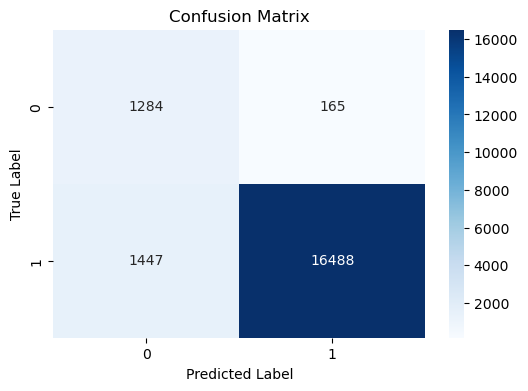

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def tune_knn(X_train, y_train, cv=3, n_iter=10):
    """
    Perform hyperparameter tuning for KNN using RandomizedSearchCV.
    """
    # Define the KNN model
    knn = KNeighborsClassifier()

    # Define the hyperparameter space
    param_distributions = {
        'n_neighbors': [3, 5, 7, 9],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }

    # Create RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(
        knn,
        param_distributions,
        n_iter=n_iter,  # Limit number of iterations
        cv=cv,  # Cross-validation folds
        scoring='accuracy',
        return_train_score=True,
        verbose=1,
        n_jobs=-1
    )

    # Perform randomized search
    randomized_search.fit(X_train, y_train)

    # Print results
    print("\nRandomized Search Results for KNN:")
    print(f"Best parameters: {randomized_search.best_params_}")
    print(f"Best cross-validation score: {randomized_search.best_score_:.4f}")

    return randomized_search.best_estimator_

def train_and_evaluate_knn_model(model, X_test, y_test):
    """
    Evaluate the KNN model and visualize the results.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Tuning hyperparameters with a fast method
best_knn_model = tune_knn(X_train, y_train)

# Evaluate the best model on the test set
train_and_evaluate_knn_model(best_knn_model, X_test, y_test)


In [52]:
def tune_bernoulli_nb(X_train, y_train, cv=5):
    # Create the pipeline with imputer and classifier
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', BernoulliNB_Scratch())
    ])

    # Define the parameter grid
    param_grid = {
        'classifier__alpha': [0, 0.001, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0, 200.0, 500.0, 750.0, 900.0, 1000.0, 1100.0, 1250.0, 1500.0, 2500.0, 5000.0, 10000.0]
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='accuracy',
        return_train_score=True,
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Print results
    print("\nGrid Search Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Create a summary of all results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results[['param_classifier__alpha', 'mean_test_score', 'std_test_score']]
    cv_results.columns = ['alpha', 'mean_cv_score', 'std_cv_score']

    print("\nDetailed Cross-validation Results:")
    print(cv_results.to_string(index=False))

    return grid_search.best_estimator_, cv_results

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    Train the model using grid search and evaluate on test set.
    """
    # Perform grid search
    best_model, cv_results = tune_bernoulli_nb(X_train, y_train)

    # Make predictions on test set
    y_pred = best_model.predict(X_test)

    # Print classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return best_model

best_model = train_and_evaluate_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 19 candidates, totalling 95 fits

Grid Search Results:
Best parameters: {'classifier__alpha': 0.001}
Best cross-validation score: 0.9524

Detailed Cross-validation Results:
   alpha  mean_cv_score  std_cv_score
       0       0.520212      0.000015
   0.001       0.952391      0.002629
     0.1       0.952391      0.002629
     0.5       0.952391      0.002629
     1.0       0.952391      0.002629
     5.0       0.952383      0.002623
    10.0       0.952376      0.002618
   100.0       0.952248      0.002604
   200.0       0.951954      0.002662
   500.0       0.950005      0.002069
   750.0       0.950088      0.001887
   900.0       0.950336      0.002207
  1000.0       0.950156      0.002064
  1100.0       0.950028      0.002012
  1250.0       0.949810      0.002003
  1500.0       0.949795      0.002126
  2500.0       0.949020      0.002103
  5000.0       0.947048      0.002897
 10000.0       0.944753      0.002818

Classification Report on Test Set:
   

## D. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `label` column.

Note: Adjust step 1 and 2 to your implementation of the preprocessing step if you don't use pipeline API from `sklearn`.

In [54]:
# Combine training and validation data
X_train_submission = pd.concat([
    train_data[binary_features],
    val_data[binary_features]
])

y_train_submission = pd.concat([
    train_data['label'],
    val_data['label']
])

# Create and fit the KNN model
model_scratch_submission = KNeighborsClassifierScratch(
    n_neighbors=5, metric='euclidean', weights='uniform'
)
model_scratch_submission.fit(X_train_submission.values, None, y_train_submission.values)

# Save the trained model to a pickle file
with open('model_knn_submission.pkl', 'wb') as file:
    pickle.dump(model_scratch_submission, file)
print("Model saved successfully to model_knn_submission.pkl!")

# Load the model from the pickle file
with open('model_knn_submission.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")

# Use the loaded model to make predictions on df_kaggle
kaggle_predictions = loaded_model.predict(processed_test[binary_features].values)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,  # Assuming `test_ids` contains the IDs for df_kaggle
    'label': kaggle_predictions
})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)

# Print results
print("\nSubmission file has been created successfully!")
print("\nFirst few rows of submission file:")
print(submission.head())

Model saved successfully to model_knn_submission.pkl!
Model loaded successfully!

Submission file has been created successfully!

First few rows of submission file:
    id  label
0   48      1
1   68      0
2   76      1
3  155      1
4  167      1


In [55]:
# Combine training and validation data
X_train_submission = pd.concat([
    train_data[binary_features],
    val_data[binary_features]
])

y_train_submission = pd.concat([
    train_data['label'],
    val_data['label']
])

# Create and fit the model
model_scratch_submission = BernoulliNB_Scratch(alpha=0.001)
model_scratch_submission.fit(X_train_submission, y_train_submission)

# Save the trained model to a pickle file
with open('model_scratch_submission.pkl', 'wb') as file:
    pickle.dump(model_scratch_submission, file)
print("Model saved successfully to model_scratch_submission.pkl!")

# Load the model from the pickle file
with open('model_scratch_submission.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")

# Use the loaded model to make predictions on df_kaggle
kaggle_predictions = loaded_model.predict(processed_test[binary_features])

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'label': kaggle_predictions
})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)

# Print results
print("\nSubmission file has been created successfully!")
print("\nFirst few rows of submission file:")
print(submission.head())

Model saved successfully to model_scratch_submission.pkl!
Model loaded successfully!

Submission file has been created successfully!

First few rows of submission file:
    id  label
0   48      1
1   68      0
2   76      1
3  155      1
4  167      1


# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?

### Number 1

##### KNN
Based on the confusion matrix and classification report, our KNN model demonstrates significantly better performance in identifying non-phishing URLs (Class 1) compared to phishing URLs (Class 0). The model achieves a precision of 99% and a recall of 93% for non-phishing URLs, indicating high reliability in its positive predictions for safe URLs. However, when it comes to identifying phishing URLs, the model's performance drops considerably, with only 50% precision while maintaining a recall of 88%. This substantial performance difference is likely due to the imbalanced nature of our training dataset, where non-phishing URLs vastly outnumber phishing URLs. Although hyperparameter tuning improved the overall accuracy, the results suggest that further efforts are needed to achieve more balanced performance across both classes. Explanation of Recall and Precision for Class 1 and Class 0

*   When the model says a URL is safe, it is correct 99% of the time (high precision)
*   Out of all the actual non-phishing URLs, the model correctly identifies 93% of them (high recall)
*   When the model says a URL is phishing, it is correct only 50% of the time (low precision)
*   Out of all the actual phishing URLs, the model correctly identifies 88% of them (high recall).

So, we can conclude that the KNN model is much better at predicting safe URLs (Class 1) compared to phishing URLs (Class 0). This is likely due to the imbalanced dataset, where the model is biased towards the majority class (safe URLs). Despite improvements through hyperparameter tuning, additional steps like class-balancing techniques or further feature engineering are necessary to improve the model's ability to identify phishing URLs while maintaining high performance for safe URLs.

##### Naive Bayes
Based on the confusion matrix and classification report, our Naive Bayes model demonstrates significantly better performance in identifying non-phishing URLs (Class 1) compared to phishing URLs (Class 0). The model achieves a precision of 99% and recall of 89% for non-phishing URLs, indicating high reliability in its positive predictions. However, when it comes to identifying phishing URLs, the model's performance drops considerably, with only 41% precision while maintaining a high recall of 91%.
This substantial performance difference is likely due too the imbalanced nature of our training dataset, where non-phishing URLs have a lot more data than the phishing URLs. Although we implemented preprocessing steps to address this imbalance, the results suggest that our current approach requires further optimization to achieve more balanced performance across both classes.
Explanation regarding the recall and precision of class 1 and class 0
* When the model says a URL is safe, it's right 99% of the time
* Out of all the actually safe URLs, it correctly caught 89% of them
* When the model says a URL is phishing, it's only right 41% of the time
* Out of all the actual phishing URLs, it caught 91% of them
So we can conclude that the model is better at predicting a safe URL because of the imbalanced dataset.

### Number 2
The KNN model achieves slightly better performance than Naive Bayes on the phishing detection dataset due to its ability to capture complex feature relationships without relying on independence assumptions. Features like URLLength and ObfuscationRatio are interdependent, which KNN models effectively through distance calculations, unlike Naive Bayes. KNN also adapts better to non-Gaussian feature distributions and imbalanced data by using distance-weighted voting, improving its ability to detect phishing URLs (Class 0). Its flexibility in hyperparameter tuning and robustness to noisy features further contribute to its slight edge in performance for the dataset.
<br><br>
The Naive Bayes performed worse than The KNN likely due to the nature of Naive Bayes that assumes features do not correlate with other features. Theoritically, each features in the dataset has some correlations that will affect the outcome of the label, but as the name Naive suggest, Naive Bayes don't account any correlation between each feature. This is probably the main reason why Naive Bayes performs worse in this context. Although it has a worse public score, Naive Bayes performs at a much faster pace when predicting the data as it uses probability while training and only needs 1 pass for predicting unseen data.
<br><br>
So to conclude, KNN performs better than Naive Bayes on predicting Phishing URL due to it's algorithm, but Naive Bayes have a much faster time to train and predict unseen data.

### Number 3
For the dataset that is given, it's better to impute the data because of the huge amount of missing data (almost all features has a 30-50% rate of missing values from the EDA we have done earlier). If we decided to drop all of the data with missing values, we would lose a lot of the data that is important for training and validating our models. Hence, this will results to a more inaccurate machine learning model.

### Number 4
Feature scaling is a crucial preprocessing step in building machine learning models because it normalizes the range of independent variables, ensuring all features are on a comparable scale. This is especially important for models like K-Nearest Neighbors (KNN), which rely on distance metrics to calculate proximity. Without scaling, features with larger ranges dominate distance calculations, leading to biased results and reduced accuracy. By standardizing the ranges of features, scaling ensures balanced contributions, enhancing the model's performance and reliability.

In contrast, feature scaling has minimal to no direct impact on Bernoulli Naive Bayes since it operates on binary data (0s and 1s) that represent the presence or absence of features. However, when numerical data requires binarization as part of preprocessing, scaling can ensure consistent thresholds, improving the binarization process and preventing skewed results. This makes scaling indirectly beneficial for datasets with non-binary features.

For our case, we use specific scaling methods to address various data characteristics: power transformers for skewed features to normalize distributions, standard scalers for general numerical features to standardize ranges, MinMax scalers for ratio features (e.g., [0,1]) to preserve relationships, and type conversion for boolean features. These techniques prevent potential issues like longer model convergence times, local optima, biased predictions favoring high-scale features, and poor interaction handling. Properly applying these scaling methods ensures our models perform efficiently and reliably across different feature types.